# Analisis Exploratorio de Datos de PE La Castellana

In [1]:
import sys 
print(sys.version)

3.11.8 | packaged by Anaconda, Inc. | (main, Feb 26 2024, 21:34:05) [MSC v.1916 64 bit (AMD64)]


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
#import requests

# Evaluate models
from utilsforecast.losses import mae, mse, rmse, mape, smape, mase
from utilsforecast.evaluation import evaluate

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score

from dateutil.parser import parse 

import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({'figure.figsize': (21,7), 'figure.dpi':120})
%matplotlib inline

##mis funciones
#from datetime import timedelta #si no se define dentro de la funcion arroja error
from clean_data import remover_valores_repetidos
from clean_data import rango_fechas_repe
from clean_data import rango_fechas_repe_exc
from clean_data import weighted_circular_mean
from clean_data import wind_average

from smec_energy import calcular_energia_lcas,smec_data

El dataset que se va a trabajar corresponde al Parque Eólico La Castellana ubicado en Bahia Blanca, Buenos Aires, Argentina.

In [3]:
#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_LAC_SOTR_2019_2024_horario.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\PARQUE_LAC\\Datos_LAC_SOTR_2019_2024_horario.csv'

df = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S.%f', delimiter=';', header=0)


#da error al leer el csv para los campo que tienen el punto como separador de miles (converti el formato del a nuemero 
#para columnas PresionAtm ), en el excel formatear estas columnas en personalizado standard

In [4]:
df.head()

FechaHora  TotPwrWTGs  Nro_Available_WTGs  VelViento  \
0 2019-02-02 01:00:00       45.18               30.83       4.15   
1 2019-02-02 02:00:00       51.07               32.00       6.13   
2 2019-02-02 03:00:00       44.95               32.00       4.19   
3 2019-02-02 04:00:00       68.85               32.00       6.03   
4 2019-02-02 05:00:00       60.22               32.00       9.55   

   VelVientoWTGS  DirVientoPond   Temp  HumedadRel  PresionAtm  ENERGIA_SMEC  \
0           7.41         102.19 -44.91        0.93     1010.50         44.50   
1           7.59         117.62  30.35        0.94     1011.19         50.97   
2           7.41         130.37  30.58        0.93     1011.77         44.83   
3           8.20         148.18 -41.71        0.93     1012.17         67.56   
4           7.86         155.37 -46.54        0.92     1012.63         59.14   

   ENERGIA_PRON_CAMMESA  
0                   NaN  
1                   NaN  
2                   NaN  
3                   NaN  
4                   NaN

#### Descripción del dataset
Este dataset corresponde a los datos producción de generación de energia y los meteorológicos del parque eólico La Castellana ubicado en Bahia Blanca provincia de Buenos Aires, Argentina. El parque tiene una potencia instalada de 100 Mw.

El dataset cuenta con datos desde Enero del 2019 a la actualidad.  


#### Descripción de las variables del dataset
* TotPwrWTGs: Es la suma de la energia horaria generada por cada turbina del parque. Fuente sistema Scada del parque        
* Nro_Available_WTGs: Es un contador de turbinas que estan en un estado de indisponibilidad, se infiere este estado por estar consumiendo energia auxiliar (valores de potencia en 0 o negativos)
* VelViento: Velocidad del viento promedio horario, a baja altura. Fuente Estación meteorologica del parque.
* VelVientoWTGS: Velocidad del viento promedio horario, a la altura del Nassel del aero generador 126mts. Fuente Estación meteorologica del parque.
* DirVientoPond: Dirección del viento horaria promedio ponderado con la velocidad del viento.   
* Temp: Temperatura ambiente promedio horario. Fuente Estación meteorologica del parque.
* HumedadRel: Humedad promedio horaria. Fuente Estación meteorologica del parque.
* PresionAtm: Presion atmosféria horaria. Fuente Estación meteorologica del parque.   
* ENERGIA_SMEC: Es la energia horaria neta producida medida por el medidor de energia del parque. Es por la que remunera Cammesa o el cliente. Es un poco menor que la TotPwrWTGs por que resta la energia auxiliar consumida por la propia planta para producir.   


Estas últimas 3 variables provienen de la base de datos de Cammesa y la ENERGIA_SMEC esta garantizado que es un dato de calidad por que se interroga directamente desde el medidor de energia y se utiliza para facturar.

In [5]:
#cambio nombre de las columnas
nom_colum = ['FechaHora','EnergiaWTG','aeros_disp','ws_plant','wtgs_plant','wdir_plant','temp_plant','hum_plant','pres_plant','EnergiaSMEC','energia_fc_cammesa']

df.columns = nom_colum

df.tail()

FechaHora  EnergiaWTG  aeros_disp  ws_plant  wtgs_plant  \
47634 2024-07-09 19:00:00        5.33        28.5      0.25        4.26   
47635 2024-07-09 20:00:00       10.90        30.0      0.25        4.94   
47636 2024-07-09 21:00:00       47.19        30.0      0.25        7.29   
47637 2024-07-09 22:00:00       64.91        31.0      0.25        8.22   
47638 2024-07-09 23:00:00       75.92        30.5      0.25        8.73   

       wdir_plant  temp_plant  hum_plant  pres_plant  EnergiaSMEC  \
47634      318.98       211.8      53.10     1015.67         4.96   
47635      317.40       211.8      53.83     1014.74         9.93   
47636      321.77       211.8      57.77     1014.37        44.56   
47637      320.83       211.8      59.06     1014.04        63.14   
47638      318.62       211.8      59.74     1013.65        73.74   

       energia_fc_cammesa  
47634                2.79  
47635                5.52  
47636               10.90  
47637               41.63  
47638               56.19

### Exploración de datos del parque eólico

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47639 entries, 0 to 47638
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   FechaHora           47639 non-null  datetime64[ns]
 1   EnergiaWTG          45491 non-null  float64       
 2   aeros_disp          45518 non-null  float64       
 3   ws_plant            45491 non-null  float64       
 4   wtgs_plant          45493 non-null  float64       
 5   wdir_plant          45491 non-null  float64       
 6   temp_plant          45491 non-null  float64       
 7   hum_plant           45491 non-null  float64       
 8   pres_plant          45491 non-null  float64       
 9   EnergiaSMEC         47639 non-null  float64       
 10  energia_fc_cammesa  35543 non-null  float64       
dtypes: datetime64[ns](1), float64(10)
memory usage: 4.0 MB


##### Eliminación de valores nulos para la EnergiaSMEC

In [7]:
df.dropna(subset=['EnergiaSMEC'], inplace=True)

# Eliminar la última fila por que no tiene las mediciones completas de la hora
df.drop(df.index[-1], inplace=True)

In [8]:
df.isnull().sum()

FechaHora                 0
EnergiaWTG             2148
aeros_disp             2121
ws_plant               2148
wtgs_plant             2146
wdir_plant             2148
temp_plant             2148
hum_plant              2148
pres_plant             2148
EnergiaSMEC               0
energia_fc_cammesa    12096
dtype: int64

El valor a predecir es el de EnergiaSMEC, como se puede observar para las variables meteorológicas hay valores en null y ademas debo analizar la calidad de las variables meteorológicas para detectar inconsistencias. Esto implica que hubo un problema de comunicación con la estación meteorologica o con alguno de los sensores.  

#### Analisis de inconsistencias en variable meteorológicas

In [9]:
num_vars= nom_colum[2:10]
#df[num_vars].describe().T

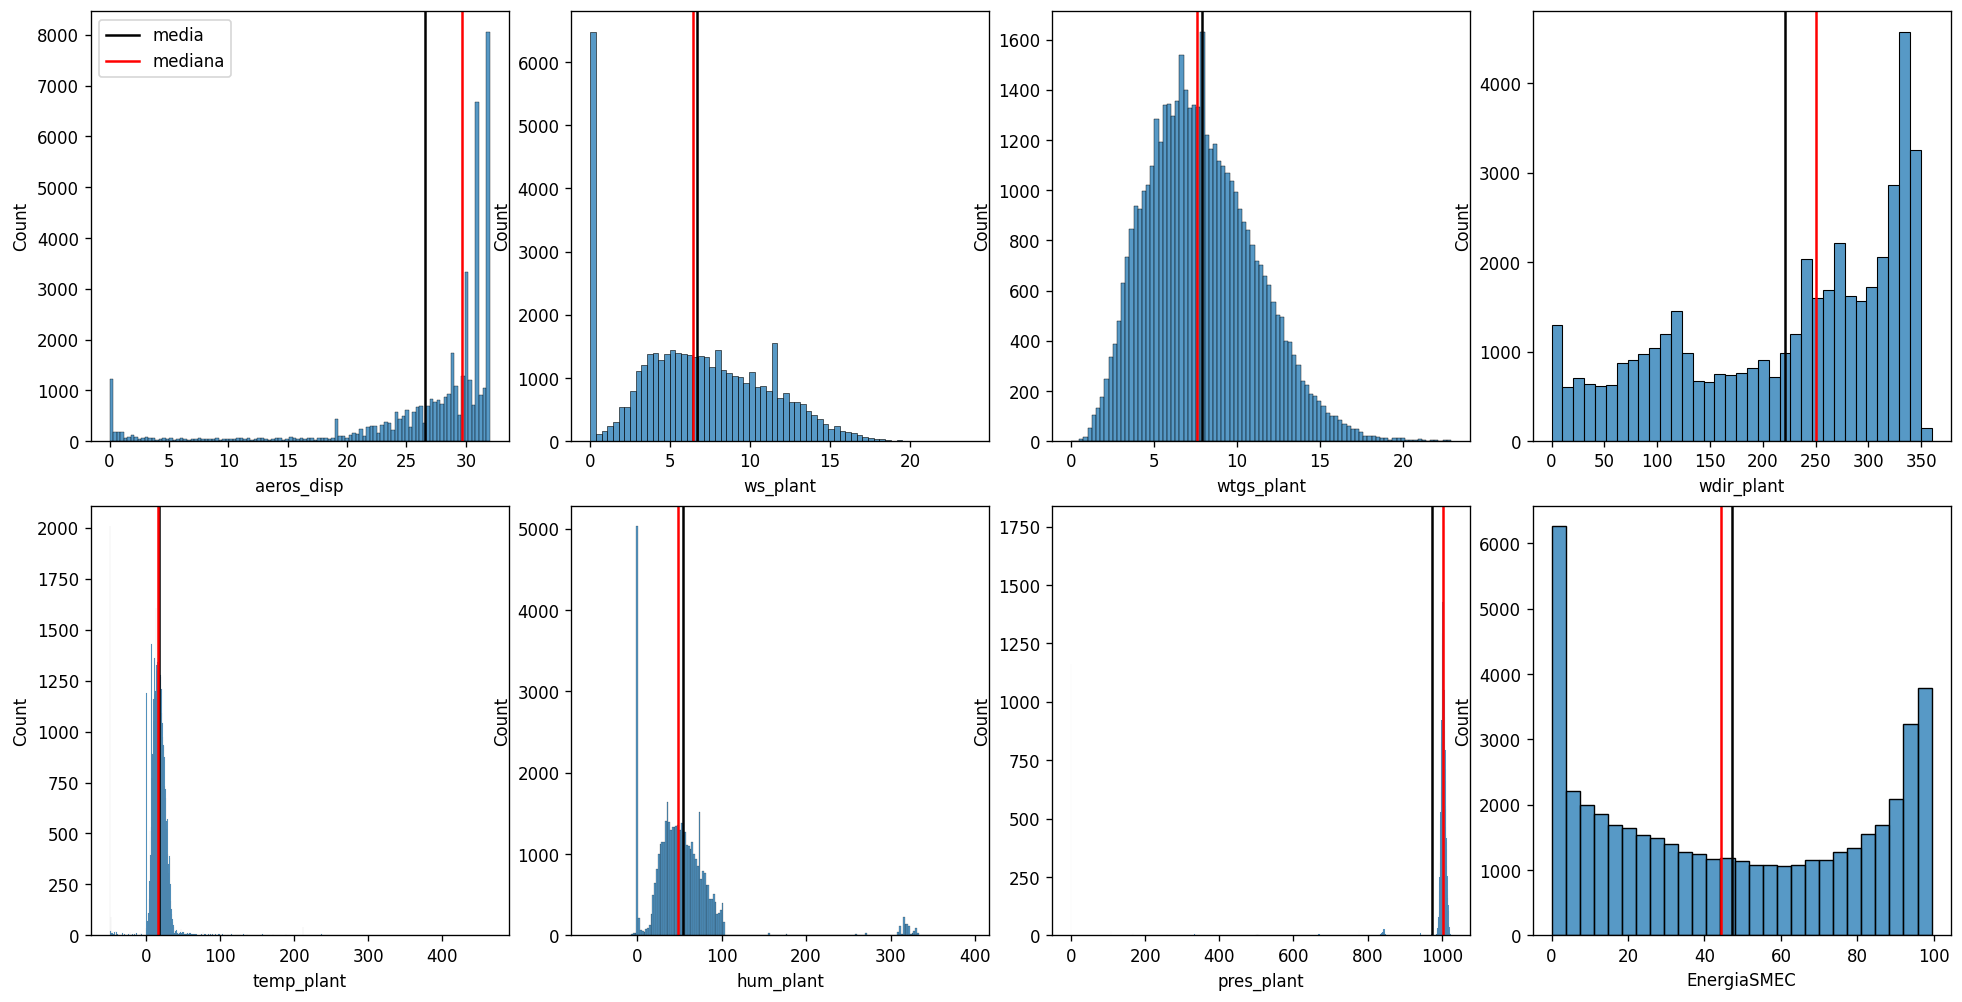

In [10]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df[col].mean(), color='k', label='media')
    ax[i].axvline(x=df[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


In [11]:
df[num_vars].describe().T

count        mean         std    min       25%       50%  \
aeros_disp   45517.0   26.525905    7.880024   0.00   25.6700    29.670   
ws_plant     45490.0    6.655735    4.299974   0.00    3.5200     6.460   
wtgs_plant   45492.0    7.877875    3.235710   0.00    5.4775     7.575   
wdir_plant   45490.0  221.421797  104.543621   0.00  127.4800   250.250   
temp_plant   45490.0   16.725533   31.465777 -49.75   10.2900    16.150   
hum_plant    45490.0   54.068926   49.574389 -55.52   30.8100    48.330   
pres_plant   45490.0  972.808764  166.221829   0.00  999.7400  1003.890   
EnergiaSMEC  47638.0   47.164655   34.497155   0.00   13.8400    44.330   

                   75%      max  
aeros_disp     31.0000    32.00  
ws_plant        9.8700    23.78  
wtgs_plant      9.9900    22.87  
wdir_plant    316.0800   359.86  
temp_plant     22.2900   464.50  
hum_plant      68.4500   394.40  
pres_plant   1008.0900  1024.66  
EnergiaSMEC    82.1275    99.44

Como se puede observar hay valores inconsistentes por los picos y outliers en todas las variables meteorológicas

### Limpieza de valores repetidos inconsistentes y de outliers de los datos meteorológicos del parque eólico

##### 1. Limpieza de la principal varible de wtgs_plant: 
Se le dara un tratamiento separado al resto de las variables por que los datos cuentan con mayor calidad y correlacion con la generación de Energia Eolica. 

In [12]:
#Borro los registros que tiene valor nulo, se presentan para todas las variables meteorolicas sin distinción de la VelVientoWTGS
df_aux=df.dropna(subset=['ws_plant'])
#reseteo el indice
df_aux.reset_index(inplace=True)

In [13]:
#Verifico que no quedan nulos
df_aux.isnull().sum()

index                     0
FechaHora                 0
EnergiaWTG                0
aeros_disp                0
ws_plant                  0
wtgs_plant                0
wdir_plant                0
temp_plant                0
hum_plant                 0
pres_plant                0
EnergiaSMEC               0
energia_fc_cammesa    11772
dtype: int64

Analizo y remuevo valores repetidos para 'wtgs_plant', cuando el valor se repite al menos 5 horas consecutivas

In [14]:
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'wtgs_plant', 5,'y')

Se removieron 666 registros repetidos
Remueve el valor 9.75 repetido 45 veces: 2021-01-05 08:00:00 - 2021-01-07 04:00:00
Remueve el valor 6.72 repetido 167 veces: 2021-10-14 09:00:00 - 2021-10-21 07:00:00
Remueve el valor 8.67 repetido 12 veces: 2021-11-10 22:00:00 - 2021-11-11 09:00:00
Remueve el valor 5.09 repetido 81 veces: 2022-11-11 04:00:00 - 2022-11-14 12:00:00
Remueve el valor 7.96 repetido 361 veces: 2023-08-02 10:00:00 - 2023-08-17 10:00:00


Como se puede observar en 5 rango de fechas se encontraron valores repetidos, y fueron eliminados para no considerarlos en el promedio

Calculo del valor promedio de la VelVientoWTGS cada saltos discretos del 0,5 MW de la EnergiaSMEC

In [15]:
# Discretizo la EnergiaSMEC cada saltos de 0.5 MW
df['EnergiaSMEC_discreta'] = df['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)
df_aux['EnergiaSMEC_discreta'] = df_aux['EnergiaSMEC'].apply(lambda x: round(x * 2) / 2)

In [16]:
# Calculo la media de 'wtgs_plant' para los valores discretos de EnergiaSMEC
df_wtgs_mean = df_aux[['EnergiaSMEC_discreta','wtgs_plant']].groupby('EnergiaSMEC_discreta').mean().reset_index()

In [17]:
df_wtgs_mean.head()

EnergiaSMEC_discreta  wtgs_plant
0                   0.0    2.738656
1                   0.5    3.559714
2                   1.0    3.675417
3                   1.5    3.870761
4                   2.0    3.920432

In [18]:
# Realizo la unión de los DataFrames en base a las columna 'EnergiaSMEC_discreta'
df_clean = df.merge(df_wtgs_mean, 
                 on=['EnergiaSMEC_discreta'], 
                 how='left', suffixes = ('', '_mean'))

In [19]:
df_clean.tail()

FechaHora  EnergiaWTG  aeros_disp  ws_plant  wtgs_plant  \
47633 2024-07-09 18:00:00        2.21        22.0      0.25        3.66   
47634 2024-07-09 19:00:00        5.33        28.5      0.25        4.26   
47635 2024-07-09 20:00:00       10.90        30.0      0.25        4.94   
47636 2024-07-09 21:00:00       47.19        30.0      0.25        7.29   
47637 2024-07-09 22:00:00       64.91        31.0      0.25        8.22   

       wdir_plant  temp_plant  hum_plant  pres_plant  EnergiaSMEC  \
47633      306.78       211.8      54.12     1016.78         1.81   
47634      318.98       211.8      53.10     1015.67         4.96   
47635      317.40       211.8      53.83     1014.74         9.93   
47636      321.77       211.8      57.77     1014.37        44.56   
47637      320.83       211.8      59.06     1014.04        63.14   

       energia_fc_cammesa  EnergiaSMEC_discreta  wtgs_plant_mean  
47633                2.34                   2.0         3.920432  
47634                2.79                   5.0         4.475270  
47635                5.52                  10.0         5.103896  
47636               10.90                  44.5         7.556556  
47637               41.63                  63.0         8.935461

In [20]:
# La funcion rango_fechas_repe devuelve los data_range con los periodos de fecha 
# que presentan valores repetidos consecutivos
dr=rango_fechas_repe(df, 'FechaHora', 'wtgs_plant', 5,'n')

Existen 666 registros repetidos


In [21]:
#Imputo el valor medio de la VelVientoWTGS para los rangos de fechas donde 
#hay valores repetidos

for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'wtgs_plant'] = df_clean.loc[mask, 'wtgs_plant_mean']

##### 2. Limpieza de la varible de DirViento, segunda en importancia: 
Debido a que la variable DirViento no presenta outliers, pero si valores repetidos se le da un tratamiento separado al resto de las variable meteorologicas

Analizo y remuevo valores repetidos para 'wdir_plant', cuando el valor se repite al menos 5 horas consecutivas

In [22]:
df_aux=remover_valores_repetidos(df_aux, 'FechaHora', 'wdir_plant', 5,'n')

Se removieron 5464 registros repetidos


In [23]:
# Calcula el promedio circular ponderado por la VelViento agrupando por EnergySMEC
DirViento_grouped_means = df_aux.groupby('EnergiaSMEC_discreta').apply(lambda x: weighted_circular_mean(x['wdir_plant'], x['wtgs_plant']), include_groups=True)

# Alinea la media calculada con el index de df_mean_meteo
df_clean['wdir_plant_mean'] = df_clean['EnergiaSMEC_discreta'].map(DirViento_grouped_means)

In [24]:
# La funcion rango_fechas_repe devuelve los data_range con los periodos de fecha 
# que presentan valores repetidos consecutivos
dr=rango_fechas_repe(df, 'FechaHora', 'wdir_plant', 5,'n')

Existen 6130 registros repetidos


In [25]:
#Imputo el valor medio de la DirViento para los rangos de fechas donde 
#hay valores repetidos

for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'wdir_plant'] = df_clean.loc[mask, 'wdir_plant_mean']

##### 3. Limpieza del resto de las variables meteorologicas (VelViento(2m),TempAmb, HumedadRel, PresionAtm): 
Estas variables presentan outliers y valores repetidos por eso se le da un tratamiento separado

In [26]:
#variables meteorológicas
meteo_vars=['ws_plant','temp_plant','hum_plant','pres_plant']

In [27]:
#Elimino los registros de outliers de TempAmb
df_aux.drop(df_aux[(df_aux['temp_plant'] <= -5) | (df_aux['temp_plant'] >= 42)].index, inplace=True)

#Elimino los registros de outliers de PresionAtm
df_aux.drop(df_aux[(df_aux['pres_plant'] <= 800) | (df_aux['pres_plant'] >= 1200)].index, inplace=True)

#Elimino los registros de outliers de HumedadRel
df_aux.drop(df_aux[(df_aux['hum_plant'] <= 0) | (df_aux['hum_plant'] >= 100)].index, inplace=True)

#Elimino los registros cuando todas las variables meteorologicas son 0
df_aux.drop(df_aux[(df_aux[meteo_vars] == 0).all(axis=1)].index, inplace=True)


In [28]:
#Reviso minimos y maximos de las variables 
df_aux[num_vars].describe().T

count         mean         std     min      25%      50%  \
aeros_disp   33105.0    26.526744    7.996837    0.00    25.83    29.83   
ws_plant     33105.0     6.857172    4.208656    0.00     3.81     6.57   
wtgs_plant   33105.0     7.849941    3.258224    0.53     5.42     7.53   
wdir_plant   33105.0   224.454646  100.914631    0.00   133.20   251.78   
temp_plant   33105.0    17.982733    7.375623   -4.39    12.57    17.65   
hum_plant    33105.0    50.840932   21.520252    0.06    34.84    49.44   
pres_plant   33105.0  1002.547268   18.142430  800.79  1000.35  1004.14   
EnergiaSMEC  33105.0    47.172272   34.664810    0.00    13.63    44.16   

                 75%      max  
aeros_disp     31.00    32.00  
ws_plant        9.86    23.78  
wtgs_plant      9.98    22.87  
wdir_plant    316.27   359.86  
temp_plant     23.03    41.96  
hum_plant      66.16    99.98  
pres_plant   1008.12  1024.66  
EnergiaSMEC    82.50    99.44

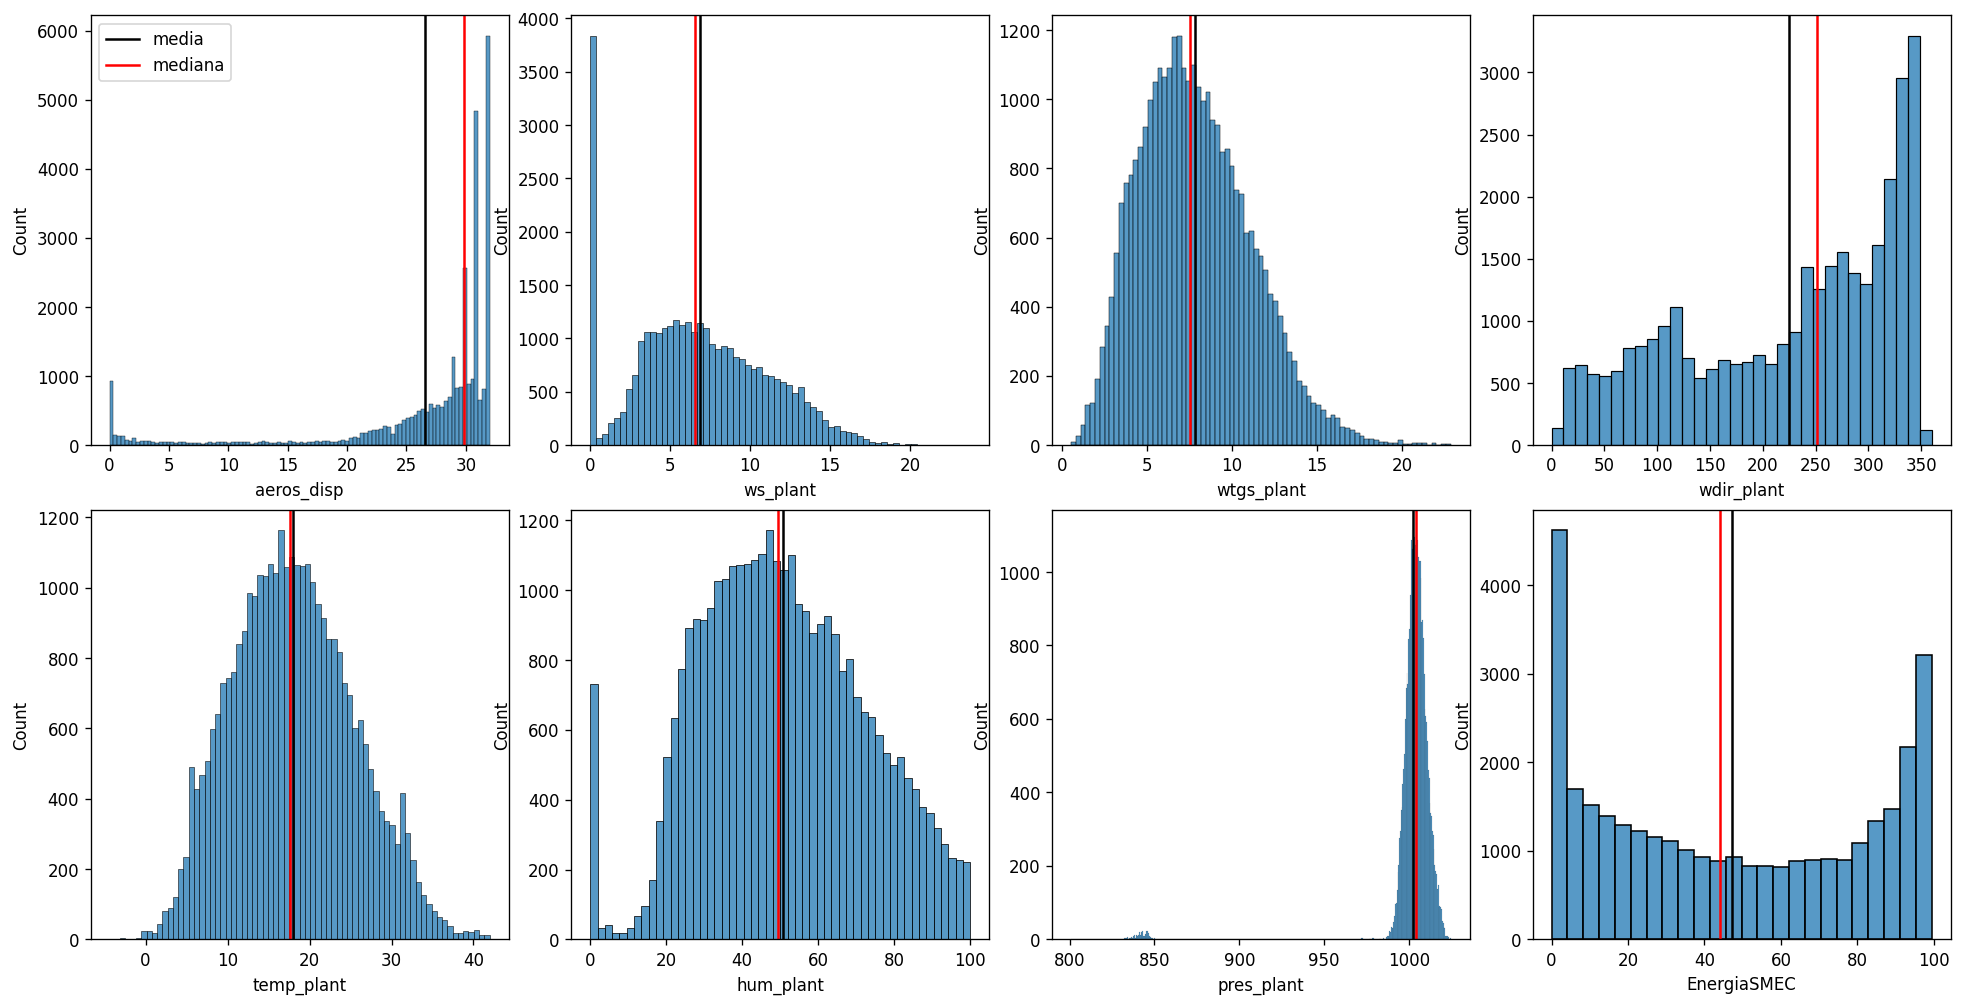

In [29]:
# Distribuciones para cada variable numerica
f, ax = plt.subplots(2, 4, figsize=(20, 10), gridspec_kw={'wspace': 0.15, 'hspace': 0.15})
ax = ax.ravel()

for i, col in enumerate(num_vars):
    sns.histplot(df_aux[col].astype(float), ax=ax[i], kde=False)
    ax[i].axvline(x=df_aux[col].mean(), color='k', label='media')
    ax[i].axvline(x=df_aux[col].median(), color='r', label='mediana')

# Turn off the last subplot if needed
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()

ax[0].legend()


In [30]:
# Calculo la media de cada columna basado en los valores discretos de EnergiaProd
meteo = ['EnergiaSMEC_discreta','ws_plant','aeros_disp','temp_plant', 'hum_plant', 'pres_plant']

df_meteo_mean = df_aux[meteo].groupby('EnergiaSMEC_discreta').mean().reset_index()

# Merge the calculated means with df_meteo_mean on the 'EnergiaSMEC_discreta' column
df_clean = pd.merge(df_clean, df_meteo_mean, on='EnergiaSMEC_discreta', suffixes=('', '_mean'))
 

In [31]:
df_clean.tail()

FechaHora  EnergiaWTG  aeros_disp  ws_plant  wtgs_plant  \
47633 2024-07-09 18:00:00        2.21        22.0      0.25        3.66   
47634 2024-07-09 19:00:00        5.33        28.5      0.25        4.26   
47635 2024-07-09 20:00:00       10.90        30.0      0.25        4.94   
47636 2024-07-09 21:00:00       47.19        30.0      0.25        7.29   
47637 2024-07-09 22:00:00       64.91        31.0      0.25        8.22   

       wdir_plant  temp_plant  hum_plant  pres_plant  EnergiaSMEC  \
47633      306.78       211.8      54.12     1016.78         1.81   
47634      318.98       211.8      53.10     1015.67         4.96   
47635      317.40       211.8      53.83     1014.74         9.93   
47636      321.77       211.8      57.77     1014.37        44.56   
47637      320.83       211.8      59.06     1014.04        63.14   

       energia_fc_cammesa  EnergiaSMEC_discreta  wtgs_plant_mean  \
47633                2.34                   2.0         3.920432   
47634                2.79                   5.0         4.475270   
47635                5.52                  10.0         5.103896   
47636               10.90                  44.5         7.556556   
47637               41.63                  63.0         8.935461   

       wdir_plant_mean  ws_plant_mean  aeros_disp_mean  temp_plant_mean  \
47633       247.403007       3.092980        20.450898        17.337510   
47634       217.790607       3.536619        25.621381        18.235048   
47635       264.203596       4.176557        27.726066        17.852842   
47636       333.126775       5.801111        29.116111        18.551019   
47637       302.172858       7.721215        29.123178        18.884112   

       hum_plant_mean  pres_plant_mean  
47633       53.146531      1005.117224  
47634       50.919286      1004.191429  
47635       51.470000      1004.143661  
47636       52.551204      1004.442593  
47637       49.856168      1003.564206

In [32]:
# Imputo en los registors nulos de las variables meteorologicas los valores medios
df_clean['aeros_disp'].fillna(df_clean['aeros_disp_mean'], inplace=True)
df_clean['ws_plant'].fillna(df_clean['ws_plant_mean'], inplace=True)
df_clean['wtgs_plant'].fillna(df_clean['wtgs_plant_mean'], inplace=True)
df_clean['wdir_plant'].fillna(df_clean['wdir_plant_mean'], inplace=True)
df_clean['temp_plant'].fillna(df_clean['temp_plant_mean'], inplace=True)
df_clean['hum_plant'].fillna(df_clean['hum_plant_mean'], inplace=True)
df_clean['pres_plant'].fillna(df_clean['pres_plant_mean'], inplace=True)

# Imputo en los registors nulos de EnergiaTGW le copio la EnergiaSMEC 
df_clean['EnergiaWTG'].fillna(df_clean['EnergiaSMEC'], inplace=True)

In [33]:
#verifico si quedo algun valor nulo
df_clean.isnull().sum()

FechaHora                   0
EnergiaWTG                  0
aeros_disp                  0
ws_plant                    0
wtgs_plant                  0
wdir_plant                  0
temp_plant                  0
hum_plant                   0
pres_plant                  0
EnergiaSMEC                 0
energia_fc_cammesa      12096
EnergiaSMEC_discreta        0
wtgs_plant_mean             0
wdir_plant_mean             0
ws_plant_mean               0
aeros_disp_mean             0
temp_plant_mean             0
hum_plant_mean              0
pres_plant_mean             0
dtype: int64

In [34]:
# Utilizo la funcion rango_fechas_repe devuelve un data_range con los periodos de fecha 
# con valores repetidos en VelViento

dr=rango_fechas_repe(df, 'FechaHora', 'ws_plant', 3,'y')

Existen 11009 registros repetidos
Valor 11.21 repetido 9 veces en las fechas: 2019-05-05 00:00:00 - 2019-05-05 08:00:00
Valor 3.55 repetido 12 veces en las fechas: 2019-05-07 21:00:00 - 2019-05-08 08:00:00
Valor 9.41 repetido 10 veces en las fechas: 2019-05-09 00:00:00 - 2019-05-09 09:00:00
Valor 4.07 repetido 17 veces en las fechas: 2019-05-09 18:00:00 - 2019-05-10 10:00:00
Valor 5.84 repetido 10 veces en las fechas: 2019-05-10 19:00:00 - 2019-05-11 04:00:00
Valor 6.68 repetido 3 veces en las fechas: 2019-05-11 06:00:00 - 2019-05-11 08:00:00
Valor 3.07 repetido 9 veces en las fechas: 2019-05-20 17:00:00 - 2019-05-21 01:00:00
Valor 3.07 repetido 4 veces en las fechas: 2019-05-21 05:00:00 - 2019-05-21 08:00:00
Valor 0.0 repetido 6 veces en las fechas: 2019-05-22 03:00:00 - 2019-05-22 08:00:00
Valor 4.21 repetido 11 veces en las fechas: 2019-05-30 00:00:00 - 2019-05-30 10:00:00
Valor 0.0 repetido 10 veces en las fechas: 2019-05-30 15:00:00 - 2019-05-31 00:00:00
Valor 0.0 repetido 4 veces

In [35]:
#Imputo el valor medio de las variables meteorologicas para los rangos de fechas donde 
#hay valores repetidos
for prev_value, rep_count, start, end in dr:
        # Filtro por el rango de fechas
        mask = (df_clean['FechaHora'] >= start) & (df_clean['FechaHora'] <= end)

        # Actualizo los valores medios
        df_clean.loc[mask, 'ws_plant'] = df_clean.loc[mask, 'ws_plant_mean']
        df_clean.loc[mask, 'temp_plant'] = df_clean.loc[mask, 'temp_plant_mean']
        df_clean.loc[mask, 'hum_plant'] = df_clean.loc[mask, 'hum_plant_mean']
        df_clean.loc[mask, 'pres_plant'] = df_clean.loc[mask, 'pres_plant_mean']


In [36]:
#Imputo la media en los registros de outliers de TempAmb
mask = (df_clean['temp_plant'] <= -5) | (df_clean['temp_plant'] >= 40)

df_clean.loc[mask, 'temp_plant'] = df_clean.loc[mask, 'temp_plant_mean']

#Imputo media en los registros de outliers de PresionAtm
mask = (df_clean['pres_plant'] <= 800) | (df_clean['pres_plant'] >= 1000)

df_clean.loc[mask, 'pres_plant'] = df_clean.loc[mask, 'pres_plant_mean']

# Agrego la 'wdir_plant' en meteo_vars
meteo_vars.append('wdir_plant')

#Imputo media en los registros que todas las variables meteorologicas son 0
mask = (df_clean[meteo_vars] == 0).all(axis=1)

# Actualizo los valores medios para todas las variables meteorologicas
df_clean.loc[mask, 'ws_plant'] = df_clean.loc[mask, 'ws_plant_mean']
df_clean.loc[mask, 'wdir_plant'] = df_clean.loc[mask, 'wdir_plant_mean']
df_clean.loc[mask, 'temp_plant'] = df_clean.loc[mask, 'temp_plant_mean']
df_clean.loc[mask, 'hum_plant'] = df_clean.loc[mask, 'hum_plant_mean']
df_clean.loc[mask, 'pres_plant'] = df_clean.loc[mask, 'pres_plant_mean']


In [37]:
df_clean=df_clean.iloc[:,0:11]

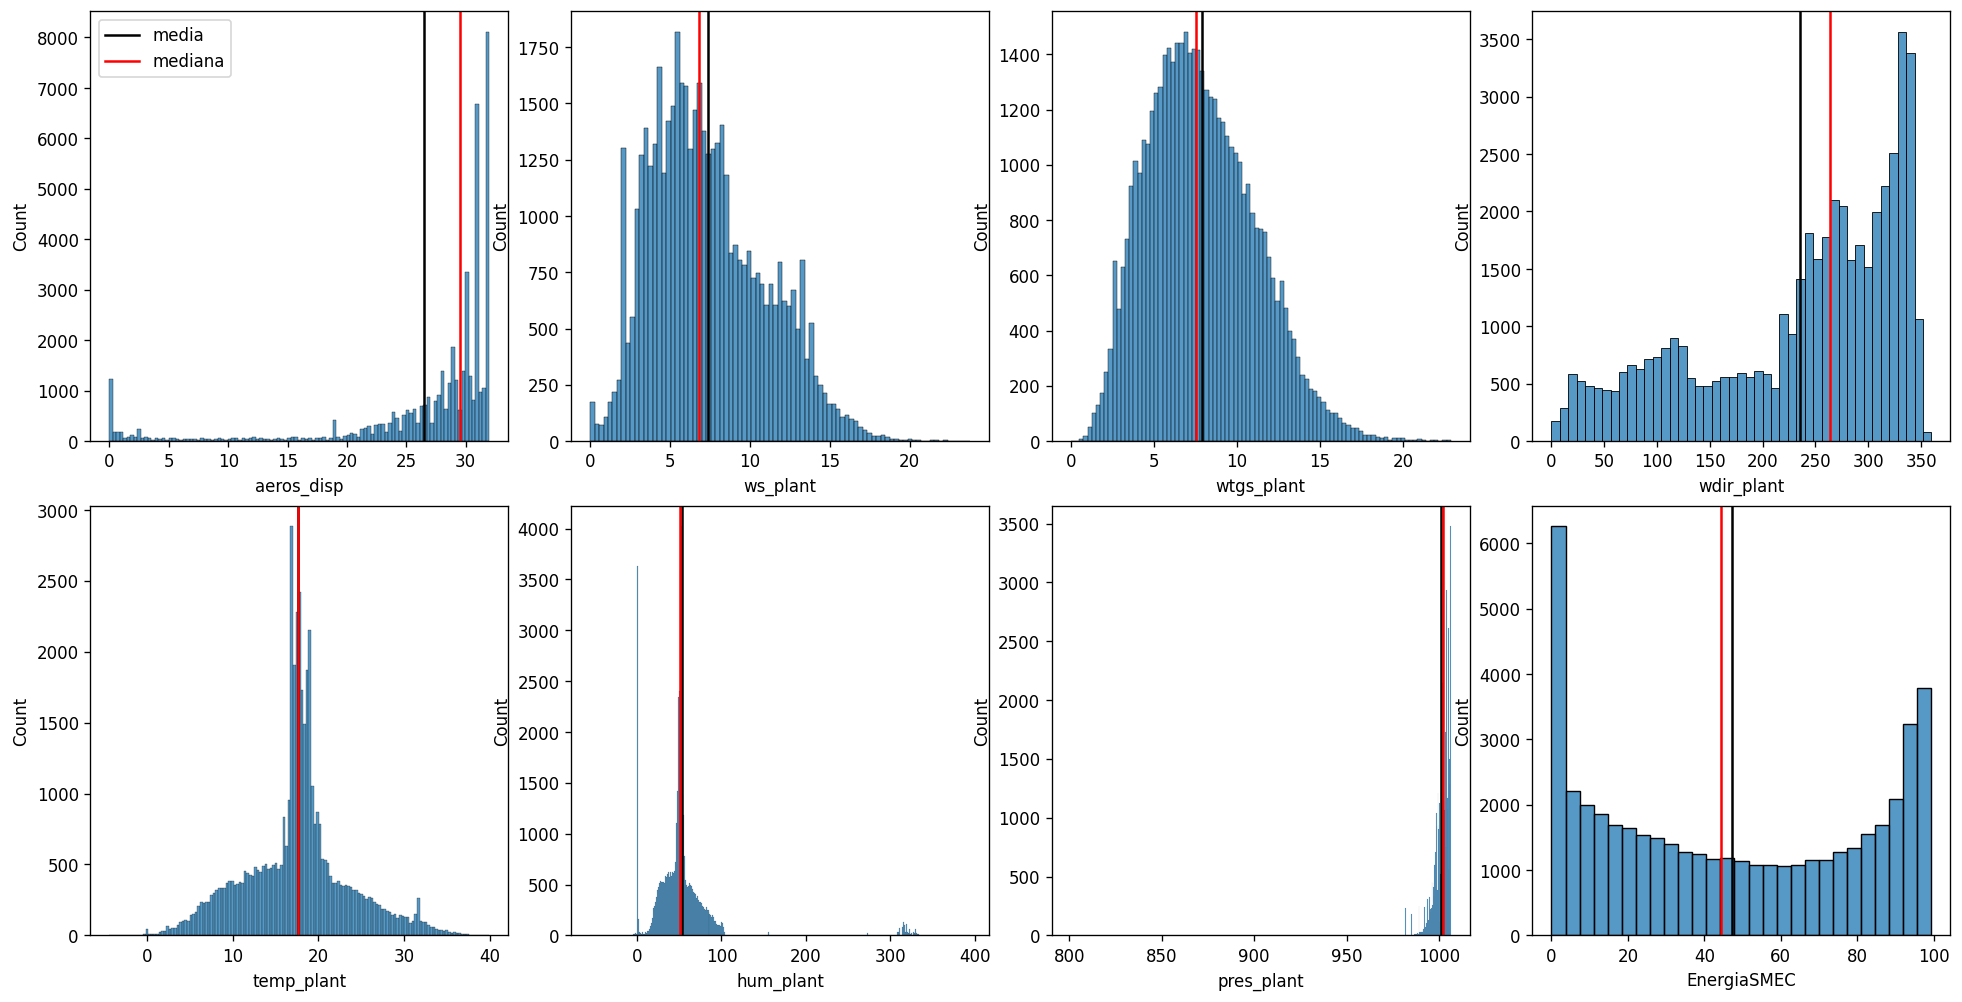

In [38]:
# Distribuciones para cada variable numerica
f,ax = plt.subplots(2,4,figsize=(20,10),gridspec_kw={'wspace':0.15,'hspace':0.15})

ax = ax.ravel()
for i,col in enumerate(num_vars):
    sns.histplot(df_clean[col].astype(float),ax=ax[i],kde=False)
    ax[i].axvline(x=df_clean[col].mean(),color='k',label='media')
    ax[i].axvline(x=df_clean[col].median(),color='r',label='mediana')    
# Turn off the last subplot
if len(num_vars) < len(ax):
    ax[len(num_vars)].remove()
   
ax[0].legend();

Como se puede observar en los histogramas el dataframe df_clean al reemplazar los valores inconsistentes de las variables metereológicas e imputarle la media en algunos casos se generan picos en las medias

<Axes: >

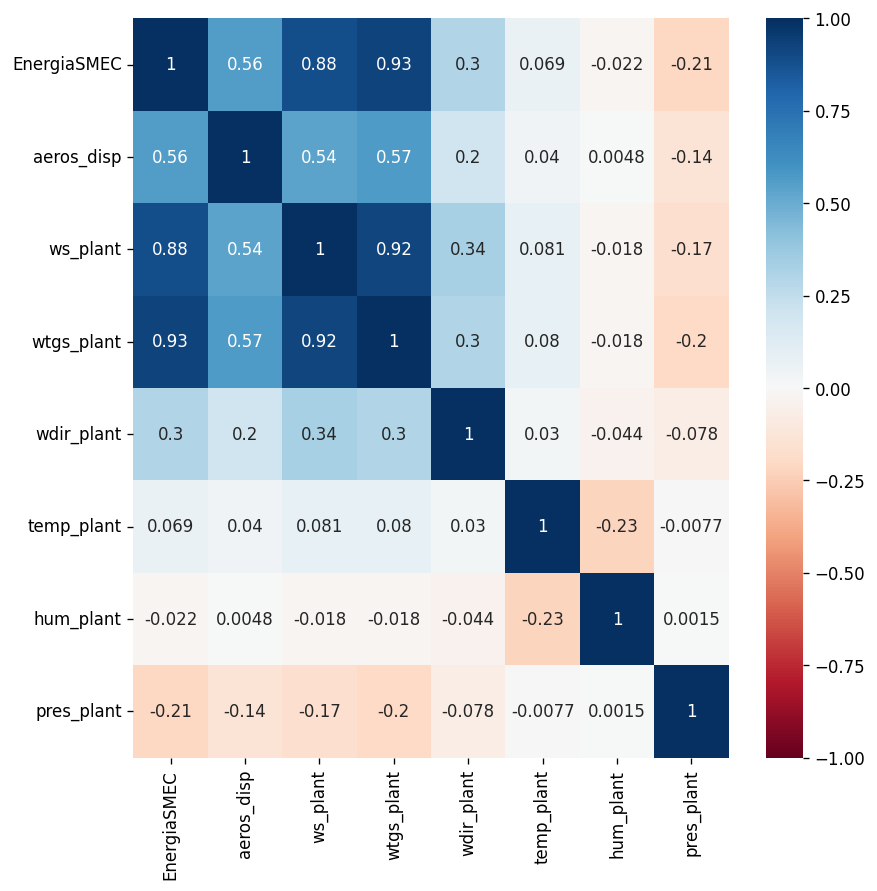

In [39]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','aeros_disp','ws_plant','wtgs_plant','wdir_plant','temp_plant','hum_plant','pres_plant']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

En la matriz de correlacion se observa claramente la fuerte correlacion entre la Generacion y la velocidad del viento y los Aerogeneradores disponibles, en menor medida la direccion y aun menor la temperatura. Lo cual es totalmente razonable la correlacion con las variables de viento y disponibilidad de maquina, en el caso de la temperatura ambiente la correlacion esta asociada a lo que se conoce en la practica como derrating de temperatura perdida de eficiencia a medida que aumenta la temperatura 

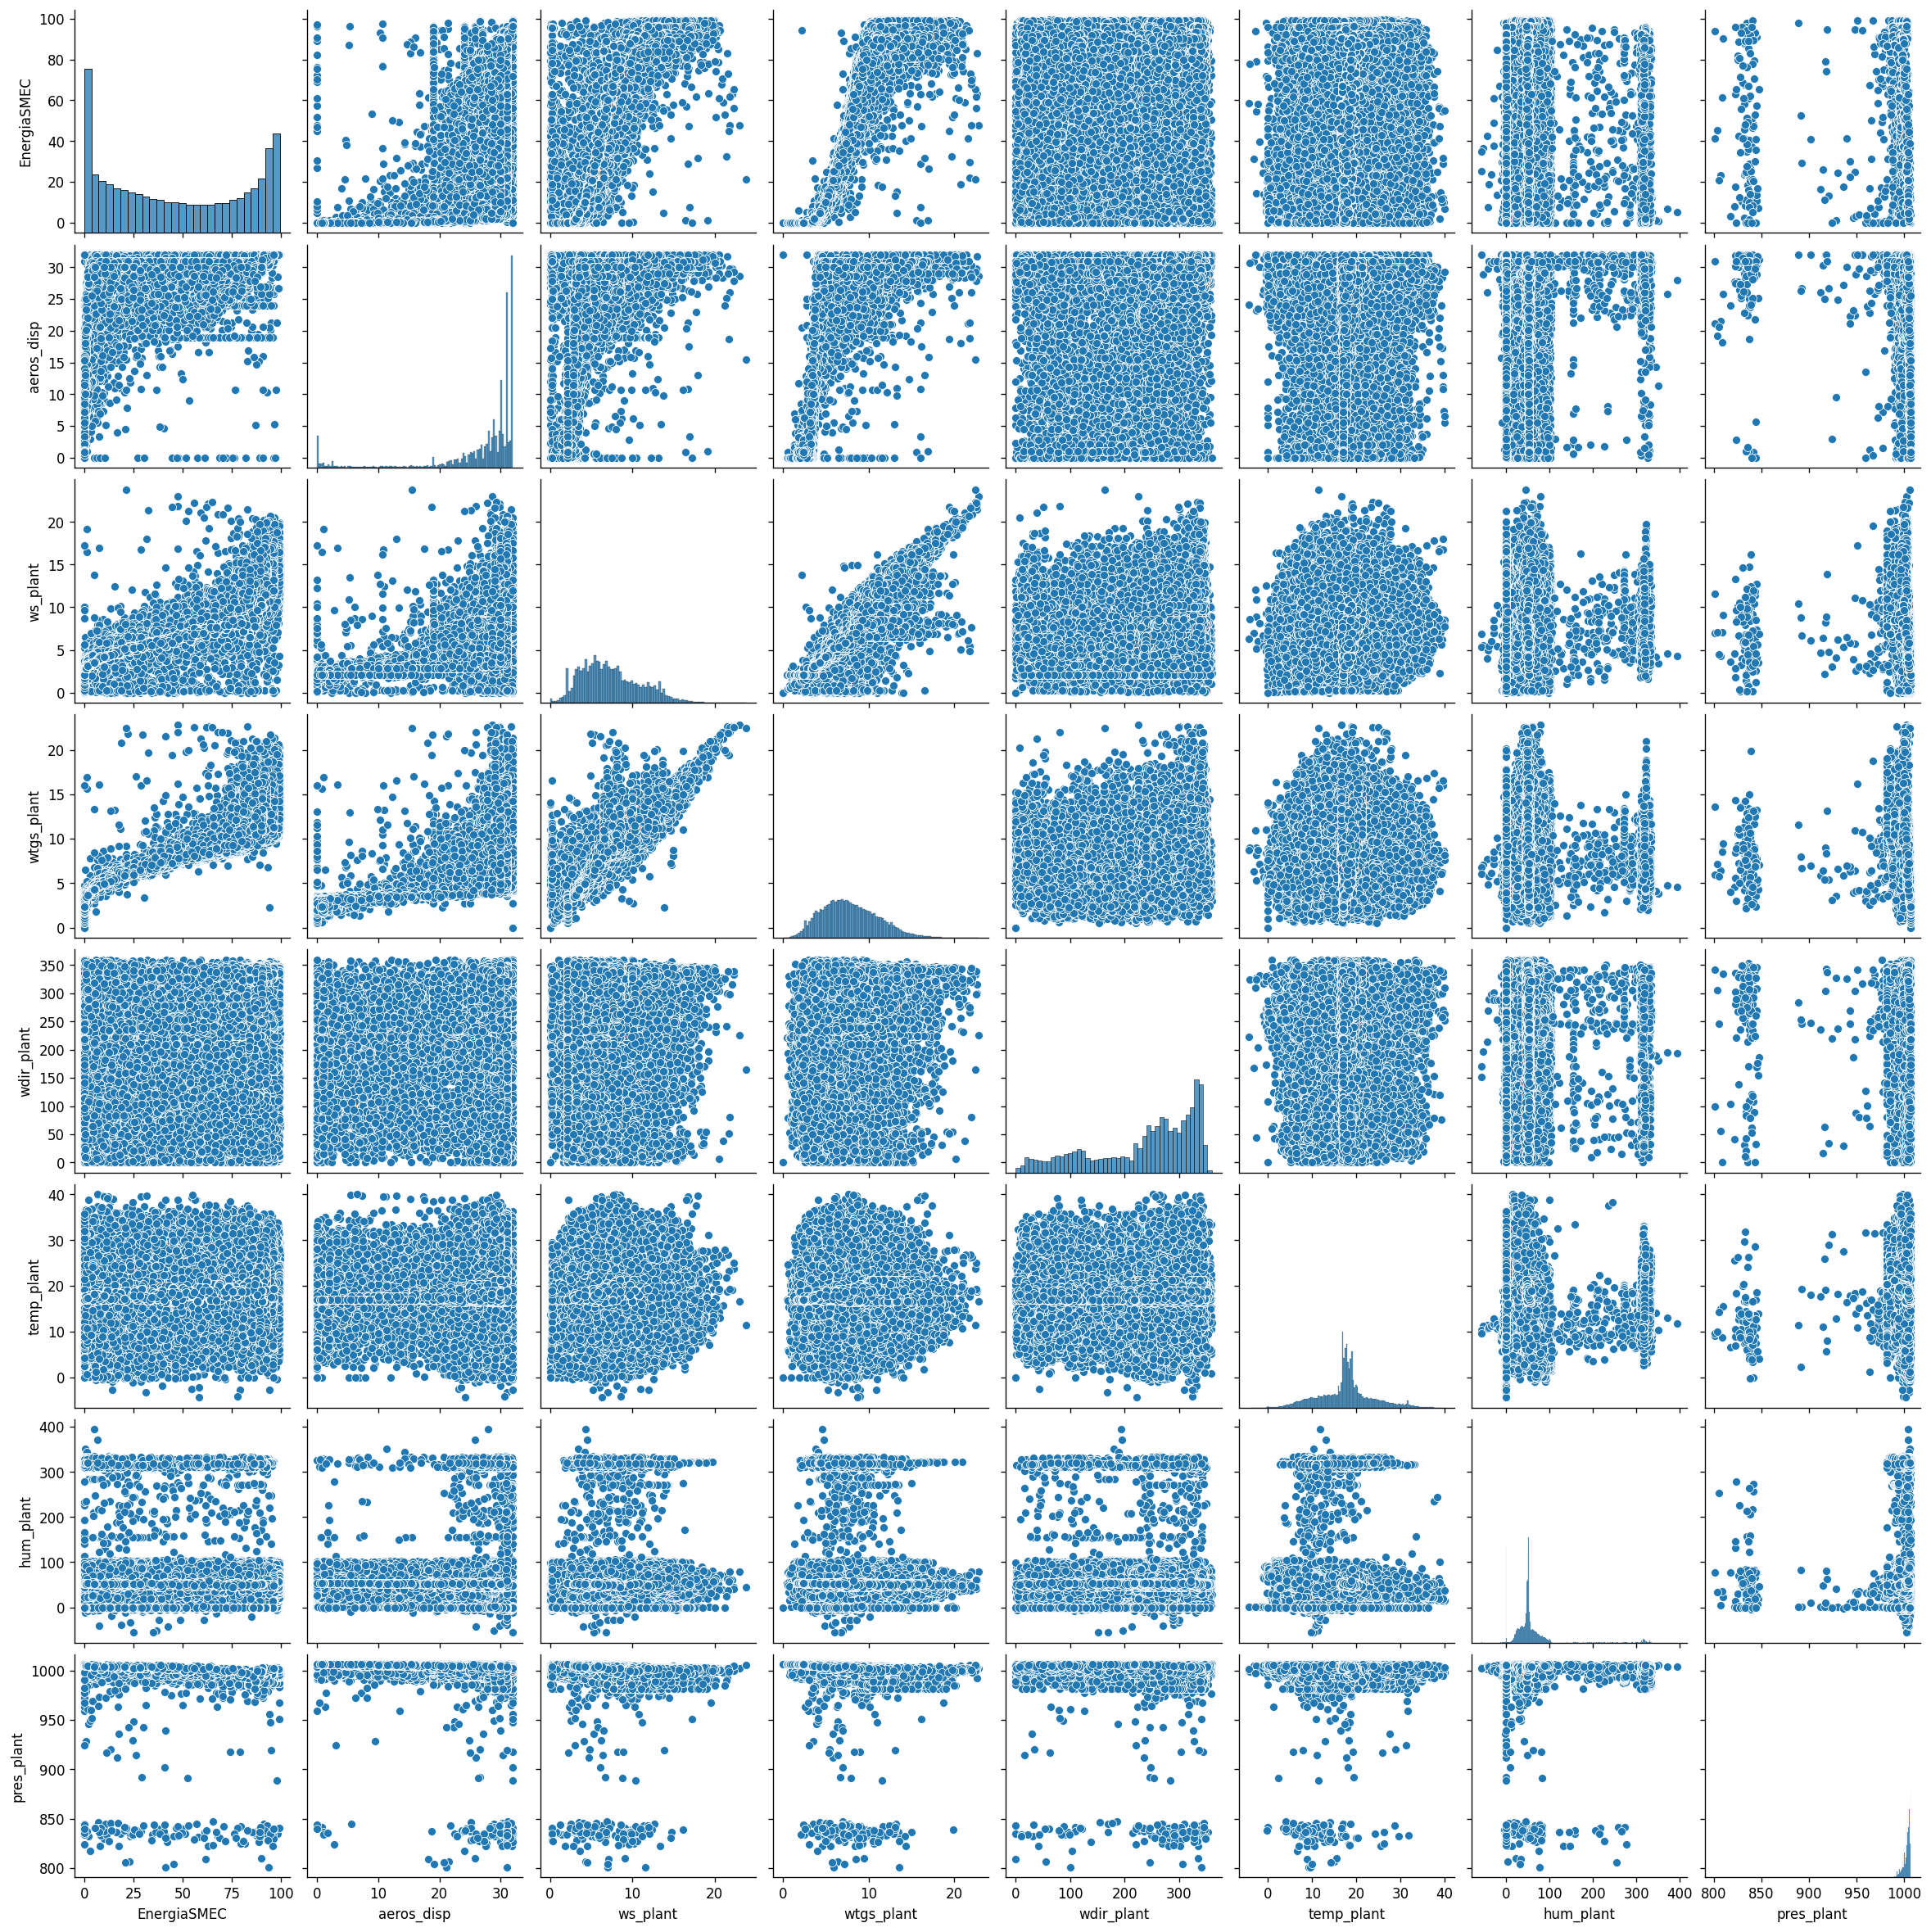

In [40]:
# Plot pairplot para ver la relación entre la distribución de las variables
sns.pairplot(df_clean[key_vars])
plt.show()

In [41]:
#dejo el archivo en un csv para analizar los datos limpios
#df_clean.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_lac.csv', sep=';', index=False, decimal=',')

In [42]:
#Se seleccionan las variables mas importantes
df_clean = df_clean[['FechaHora','EnergiaSMEC','aeros_disp','wtgs_plant','wdir_plant','temp_plant','energia_fc_cammesa']]

In [43]:
df_clean.tail()

FechaHora  EnergiaSMEC  aeros_disp  wtgs_plant  wdir_plant  \
47633 2024-07-09 18:00:00         1.81        22.0        3.66      306.78   
47634 2024-07-09 19:00:00         4.96        28.5        4.26      318.98   
47635 2024-07-09 20:00:00         9.93        30.0        4.94      317.40   
47636 2024-07-09 21:00:00        44.56        30.0        7.29      321.77   
47637 2024-07-09 22:00:00        63.14        31.0        8.22      320.83   

       temp_plant  energia_fc_cammesa  
47633   17.337510                2.34  
47634   18.235048                2.79  
47635   17.852842                5.52  
47636   18.551019               10.90  
47637   18.884112               41.63

### Datos Climaticos Historicos del SMN (Servicio Meteorológico Nacional) 
Se toman de la estación meteorologica del Aerodromo de Bahia Blanca que se encuentra a 30 Km del PE La Castellana. Las datos del servico meteorologico nacional se extraen a traves de la API de meteostat

In [44]:
#path = 'https://raw.githubusercontent.com/guilledesimone/MMA/main/Datos_LAC_SOTR_2019_2024_horario.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\METEOSTAT\\df_histo_meteostat.csv'

df_histo_smn = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M', delimiter=';', header=0) #:%.%f

In [45]:
# Añadir el sufijo _smn a las columnas especificadas
columns_to_rename = {'wspd':'wspd_smn','wdir':'wdir_smn','temp':'temp_smn','pres':'pres_smn','rhum':'rhum_smn'}
df_histo_smn.rename(columns=columns_to_rename, inplace=True)

In [46]:
# Convertir la columna 'FechaHora' a datetime
df_histo_smn['FechaHora'] = pd.to_datetime(df_histo_smn['FechaHora'], format='%d/%m/%Y %H:%M')

In [47]:
# Realizo la unión de los DataFrames

df_clean_smn = df_clean.merge(df_histo_smn, 
                 on=['FechaHora'],
                 how='left')


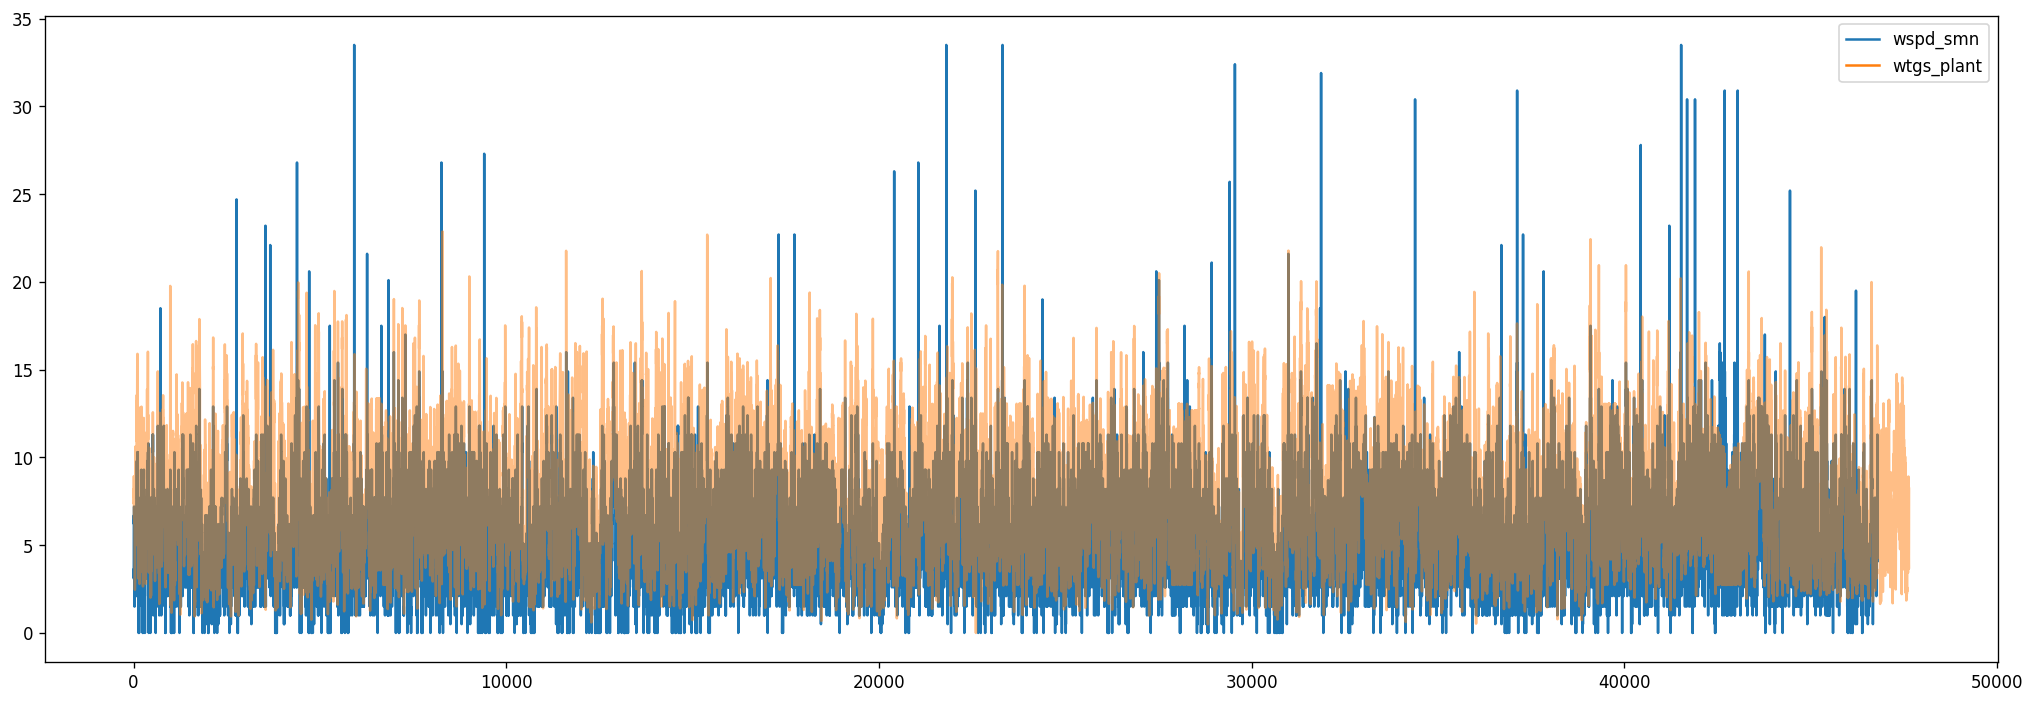

In [48]:
# Plotting specific columns
ax = df_clean_smn.plot(y=['wspd_smn', 'wtgs_plant'])  # Plot both columns

# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5

#df_clean_smn.plot(y=['temp_smn','temp_plant'])

plt.show()

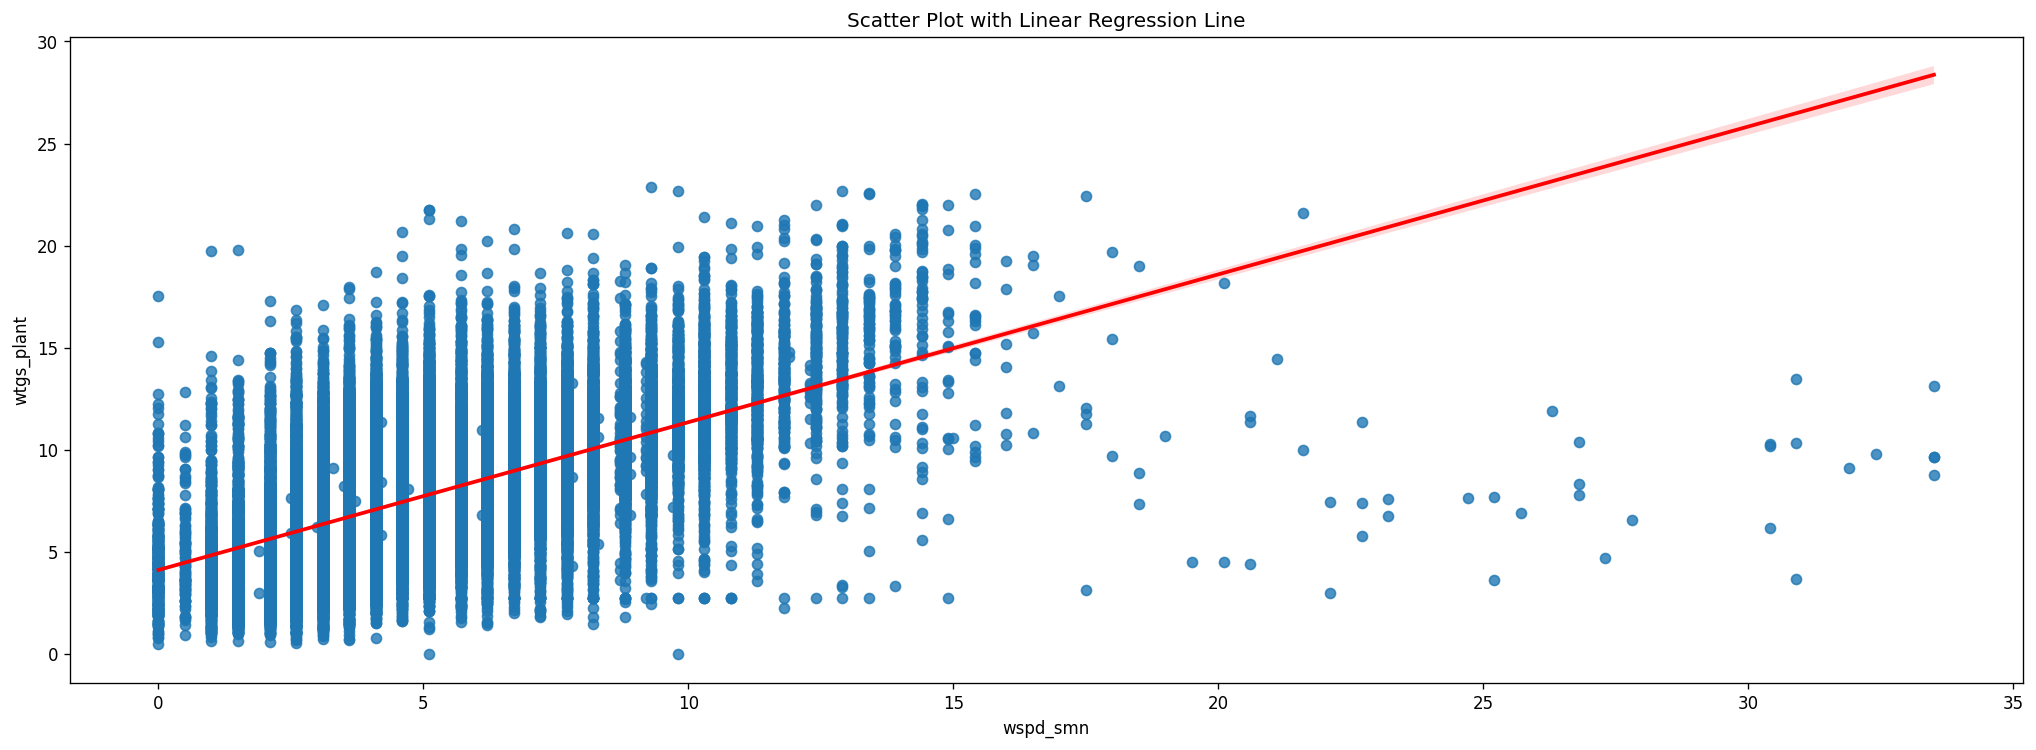

In [49]:
# Scatter plot
sns.regplot(x='wspd_smn', y='wtgs_plant', data=df_clean_smn, line_kws={'color': 'red'})
plt.xlabel('wspd_smn')
plt.ylabel('wtgs_plant')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()


#### Distribucion de la velocidad de viento del parque La Castellana vs SMN

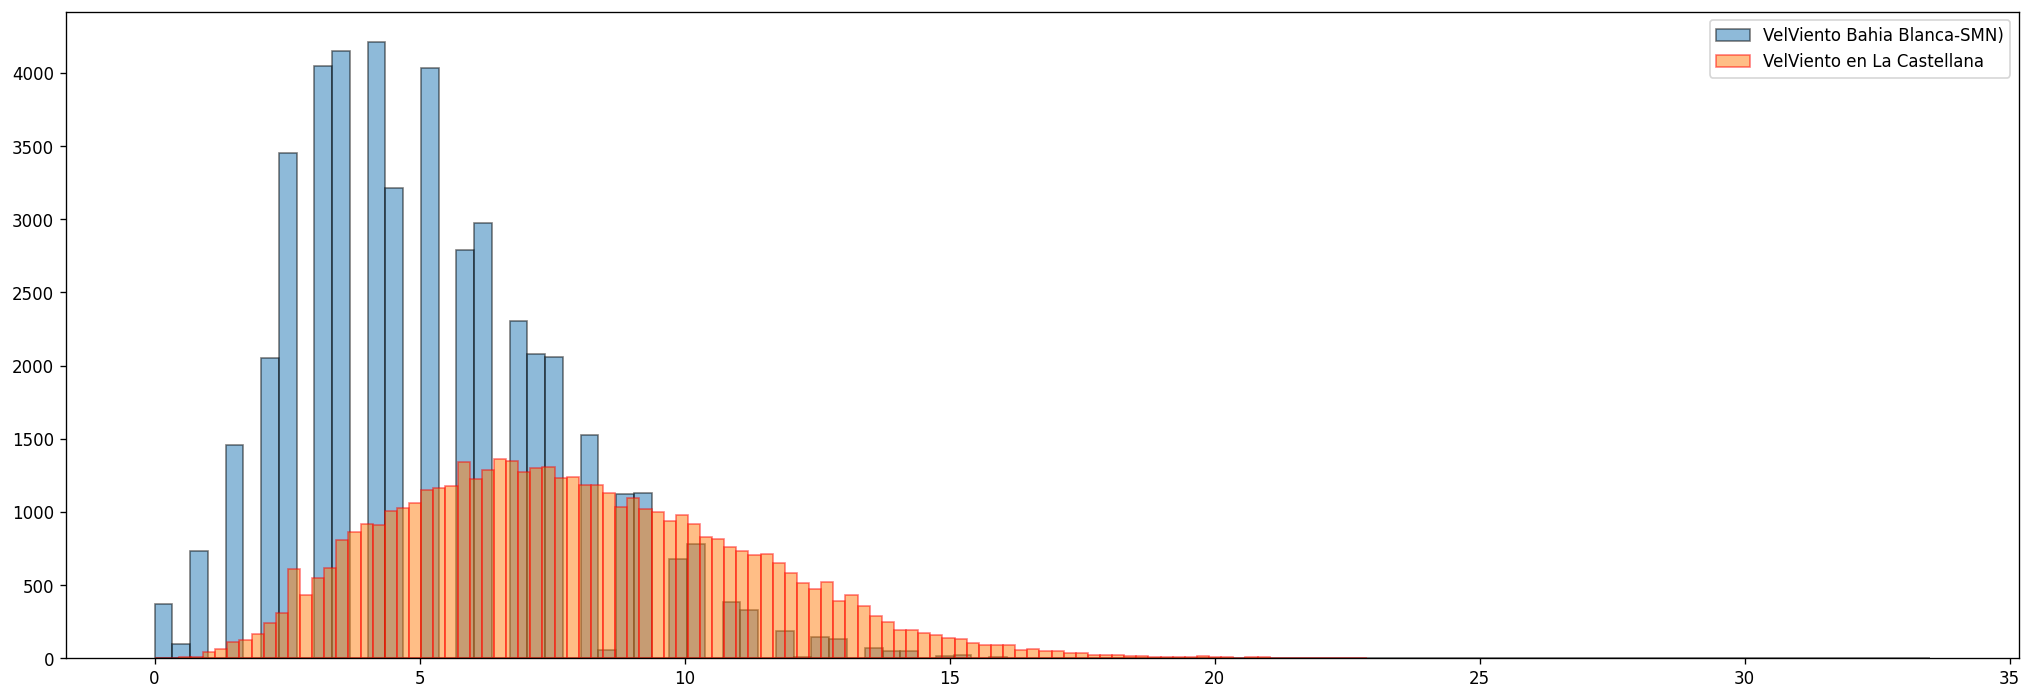

In [50]:
plt.hist(df_clean_smn['wspd_smn'], edgecolor='black', alpha=0.5, label='VelViento Bahia Blanca-SMN)', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_smn['wtgs_plant'], edgecolor='red', alpha=0.5, label='VelViento en La Castellana', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

<Axes: >

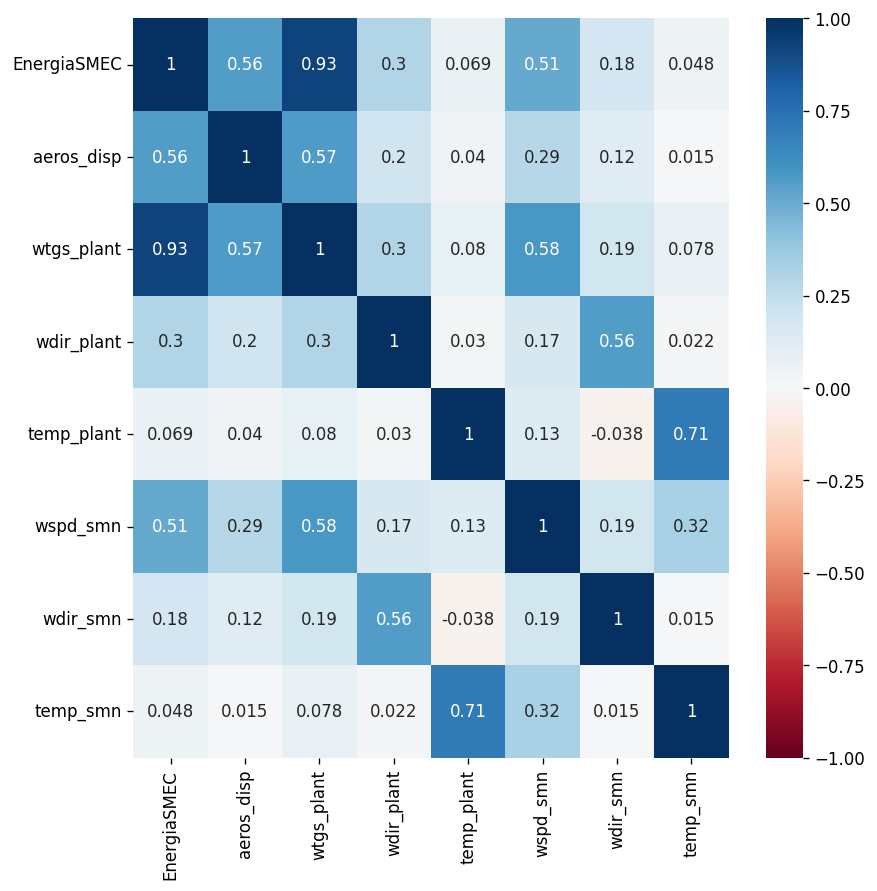

In [51]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','aeros_disp','wtgs_plant','wdir_plant','temp_plant','wspd_smn','wdir_smn','temp_smn']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_smn[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

### Datos Climaticos Históricos de ECMWF (European Centre for Medium-Range Weather Forecasts) - ERA5
ERA5 is the fifth generation ECMWF atmospheric reanalysis of the global climate

In [52]:
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ERA5\\ds_histo_era5.csv'

In [53]:
df_histo_era5 = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)


In [54]:
df_histo_era5.head()

FechaHora  ws100_ecmwf  dir100_ecmwf  temp_ecmwf  airden_ecmwf  \
0 2018-12-31 21:00:00    12.121110    357.113901   21.379415      1.169393   
1 2018-12-31 22:00:00    13.585819    359.681664   21.398169      1.170022   
2 2018-12-31 23:00:00    13.775665      0.234681   21.240099      1.170395   
3 2019-01-01 00:00:00    12.837879    358.451270   20.925970      1.171574   
4 2019-01-01 01:00:00    11.800872    354.468828   21.206610      1.170418   

   reltct_ecmwf  
0     85.904362  
1    107.978115  
2    111.052331  
3     96.544244  
4     81.496515

In [55]:
#Cast FechaHora to datetime
df_histo_era5['FechaHora'] = pd.to_datetime(df_histo_era5['FechaHora'])

# Set 'FechaHora' as the index
df_histo_era5.set_index('FechaHora', inplace=True)


In [56]:
# Realizo la unión de los DataFrames

df_clean_era5 = df_clean.merge(df_histo_era5, 
                 on=['FechaHora'],
                 how='left')

In [57]:
#Dado que los dataset tienen diferentes fechas hasta elimino registros con valores nulos
df_clean_era5 = df_clean_era5.dropna(subset=['ws100_ecmwf', 'wtgs_plant'], how='any')

In [58]:
#df_clean_era5.tail()

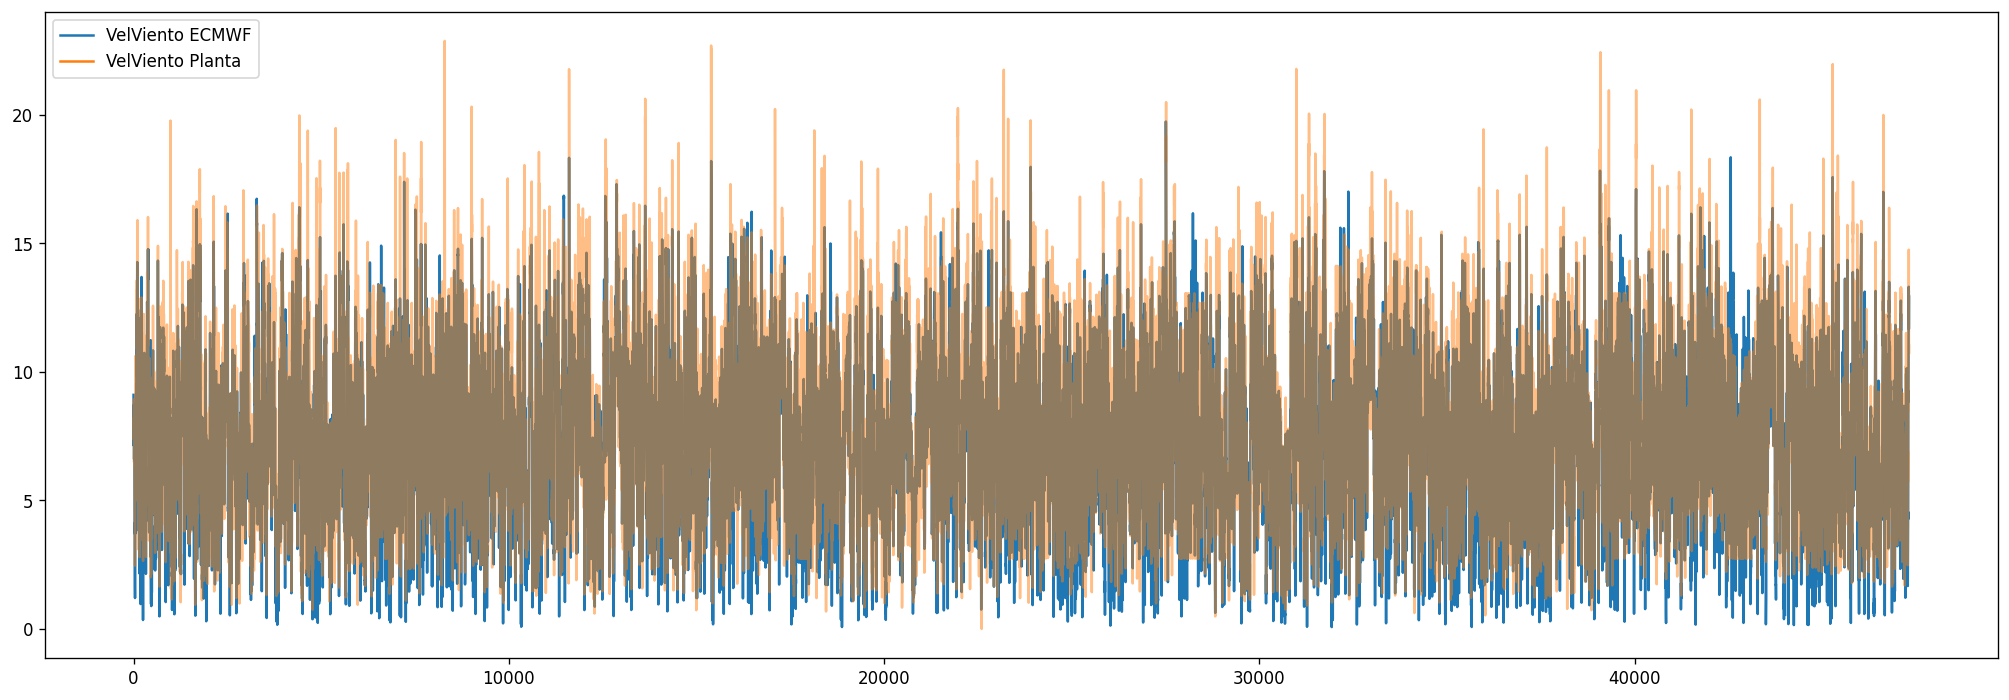

In [59]:
# Plotting specific columns
ax = df_clean_era5.plot(y=['ws100_ecmwf', 'wtgs_plant'],label=['VelViento ECMWF', 'VelViento Planta'])  # Plot both columns

# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5

plt.show()

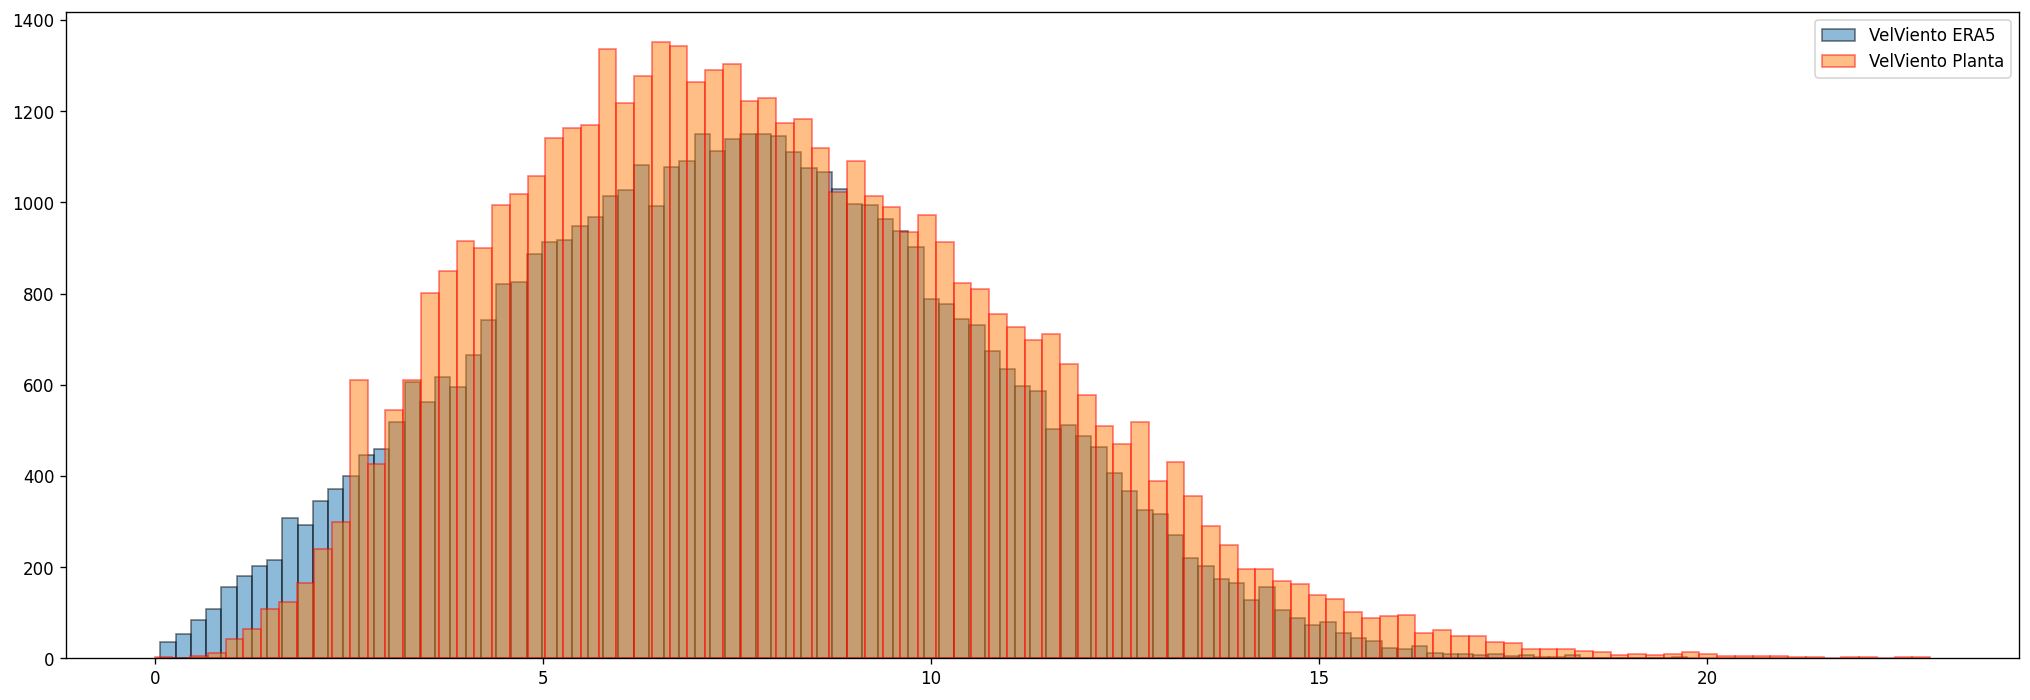

In [60]:
plt.hist(df_clean_era5['ws100_ecmwf'], edgecolor='black', alpha=0.5, label='VelViento ERA5', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_era5['wtgs_plant'], edgecolor='red', alpha=0.5, label='VelViento Planta', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

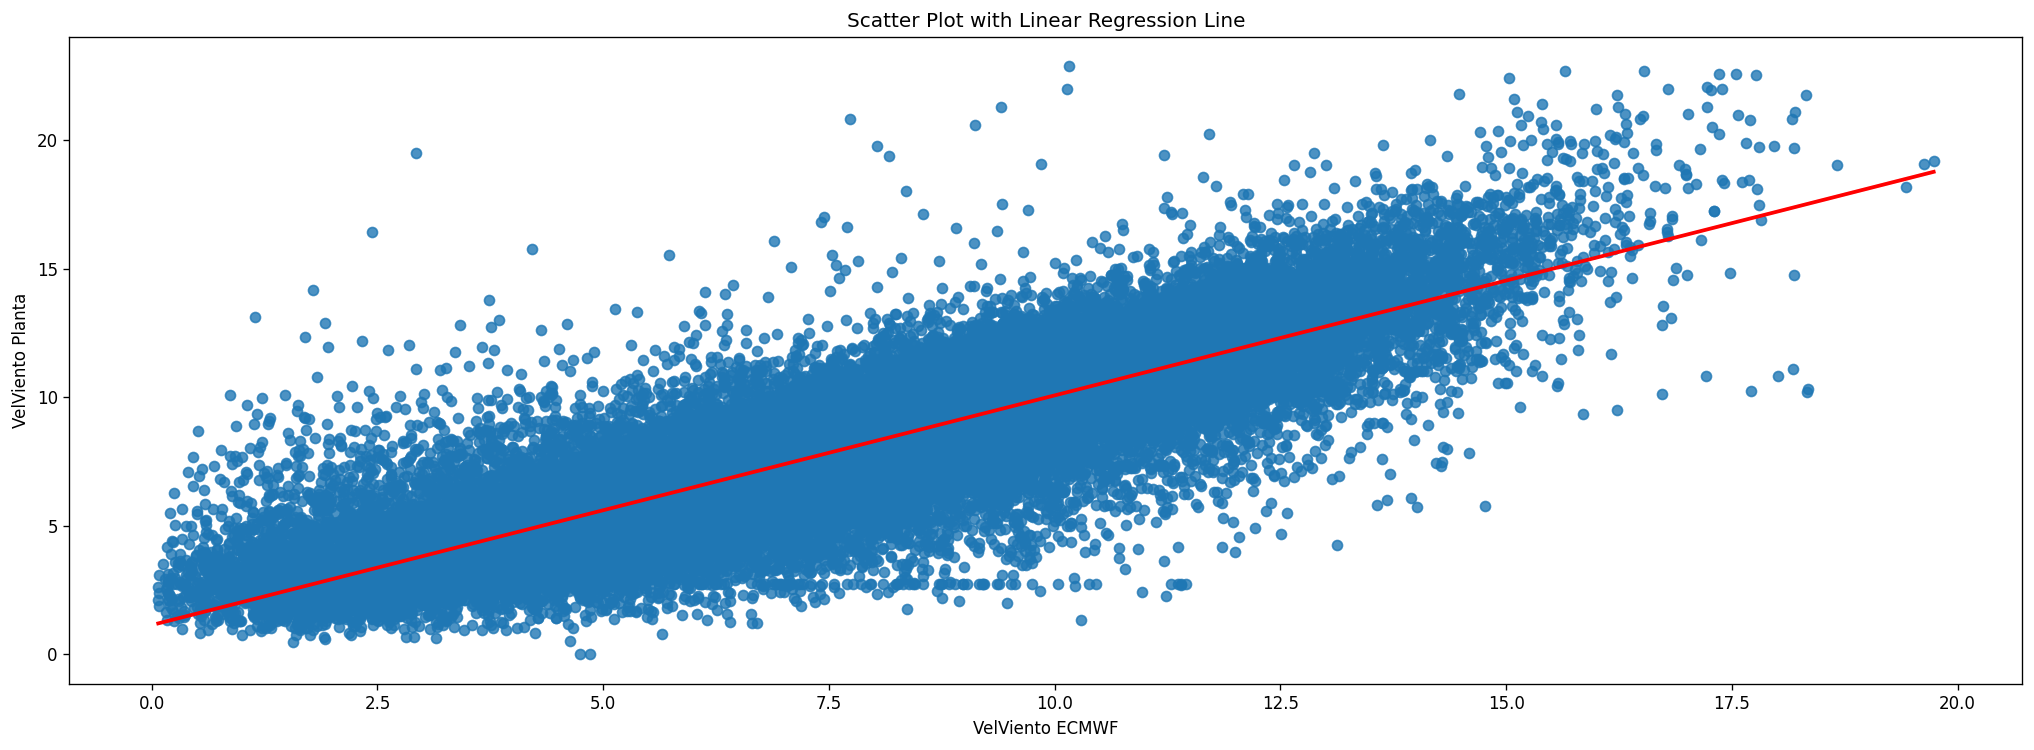

In [61]:
# Scatter plot
sns.regplot(x='ws100_ecmwf', y='wtgs_plant', data=df_clean_era5, line_kws={'color': 'red'})
plt.xlabel('VelViento ECMWF')
plt.ylabel('VelViento Planta')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()

<Axes: >

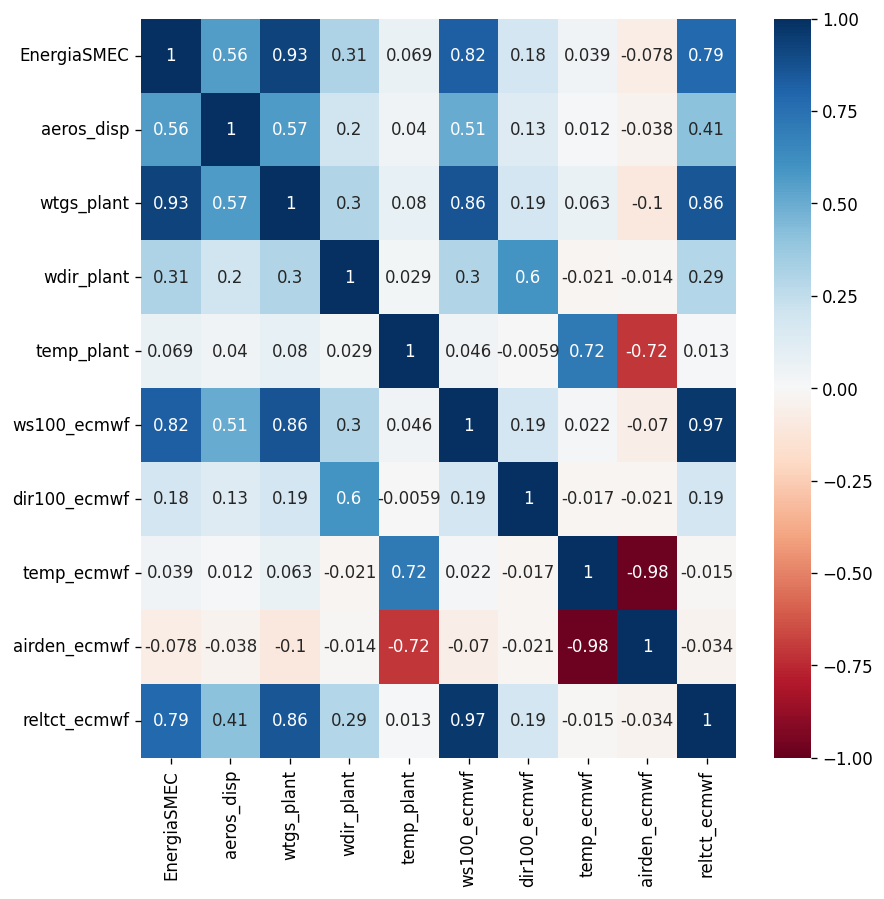

In [62]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','aeros_disp','wtgs_plant','wdir_plant','temp_plant','ws100_ecmwf','dir100_ecmwf','temp_ecmwf','airden_ecmwf','reltct_ecmwf']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_era5[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

In [63]:
#Exporto el archivo del dataset limpio
#df_clean_era5.to_csv('D:\\Documents\\MMA\\1.0 Tesis\\Datos\\df_clean_era5_0306.csv', sep=';', index=False, decimal=',')

### Datos Climáticos Historicos de GFS (GLobal Forecast System) 

Sistema de Pronóstico Global es un modelo de pronóstico del tiempo producido por los Centros Nacionales de Predicción Ambiental (NCEP) en Estados Unidos

In [64]:
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\GFS\\ds_histo_gfs_2024-06-15.csv'

In [65]:
df_histo_gfs = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%Y-%m-%d %H:%M:%S', delimiter=';', header=0)


In [66]:
#Cast FechaHora to datetime
df_histo_gfs['FechaHora'] = pd.to_datetime(df_histo_gfs['FechaHora'], dayfirst=True)

# Set 'FechaHora' as the index
df_histo_gfs.set_index('FechaHora', inplace=True)


In [67]:
df_histo_gfs.head()

ws100_gfs  dir100_gfs   temp_gfs  airden_gfs  reltct_gfs
FechaHora                                                                    
2019-02-01 03:00:00   5.552909   148.34074  21.855316    1.162925   17.929274
2019-02-01 04:00:00   5.552909   148.34074  21.855316    1.162925   17.929274
2019-02-01 05:00:00   5.552909   148.34074  21.855316    1.162925   17.929274
2019-02-01 06:00:00   6.809348   113.63219  20.449982    1.169856   27.121483
2019-02-01 07:00:00   6.809348   113.63219  20.449982    1.169856   27.121483

In [68]:
# Realizo la unión de los DataFrames

df_clean_gfs = df_histo_gfs.merge(df_clean, 
                 on=['FechaHora'],
                 how='left')

In [69]:
df_clean_gfs.dropna(subset=['EnergiaSMEC'], inplace=True)
df_clean_gfs.tail()

FechaHora  ws100_gfs  dir100_gfs   temp_gfs  airden_gfs  \
47078 2024-06-15 17:00:00    9.00076   295.73288  16.692230    1.191502   
47079 2024-06-15 18:00:00    6.18558   304.20370  16.820770    1.191498   
47080 2024-06-15 19:00:00    6.18558   304.20370  16.820770    1.191498   
47081 2024-06-15 20:00:00    6.18558   304.20370  16.820770    1.191498   
47082 2024-06-15 21:00:00    5.10889   313.42150  14.612152    1.202529   

       reltct_gfs  EnergiaSMEC  aeros_disp  wtgs_plant  wdir_plant  \
47078   48.263992        45.17       28.50        7.56      273.62   
47079   22.794186        29.07       27.67        6.72      274.43   
47080   22.794186        35.32       28.33        6.98      271.72   
47081   22.794186        27.11       27.67        6.45      270.48   
47082   15.693450        25.66       29.00        6.29      270.22   

       temp_plant  energia_fc_cammesa  
47078   19.526701               66.60  
47079   17.447568               51.35  
47080   17.779421               38.22  
47081   16.981364               42.90  
47082   18.761111               36.01

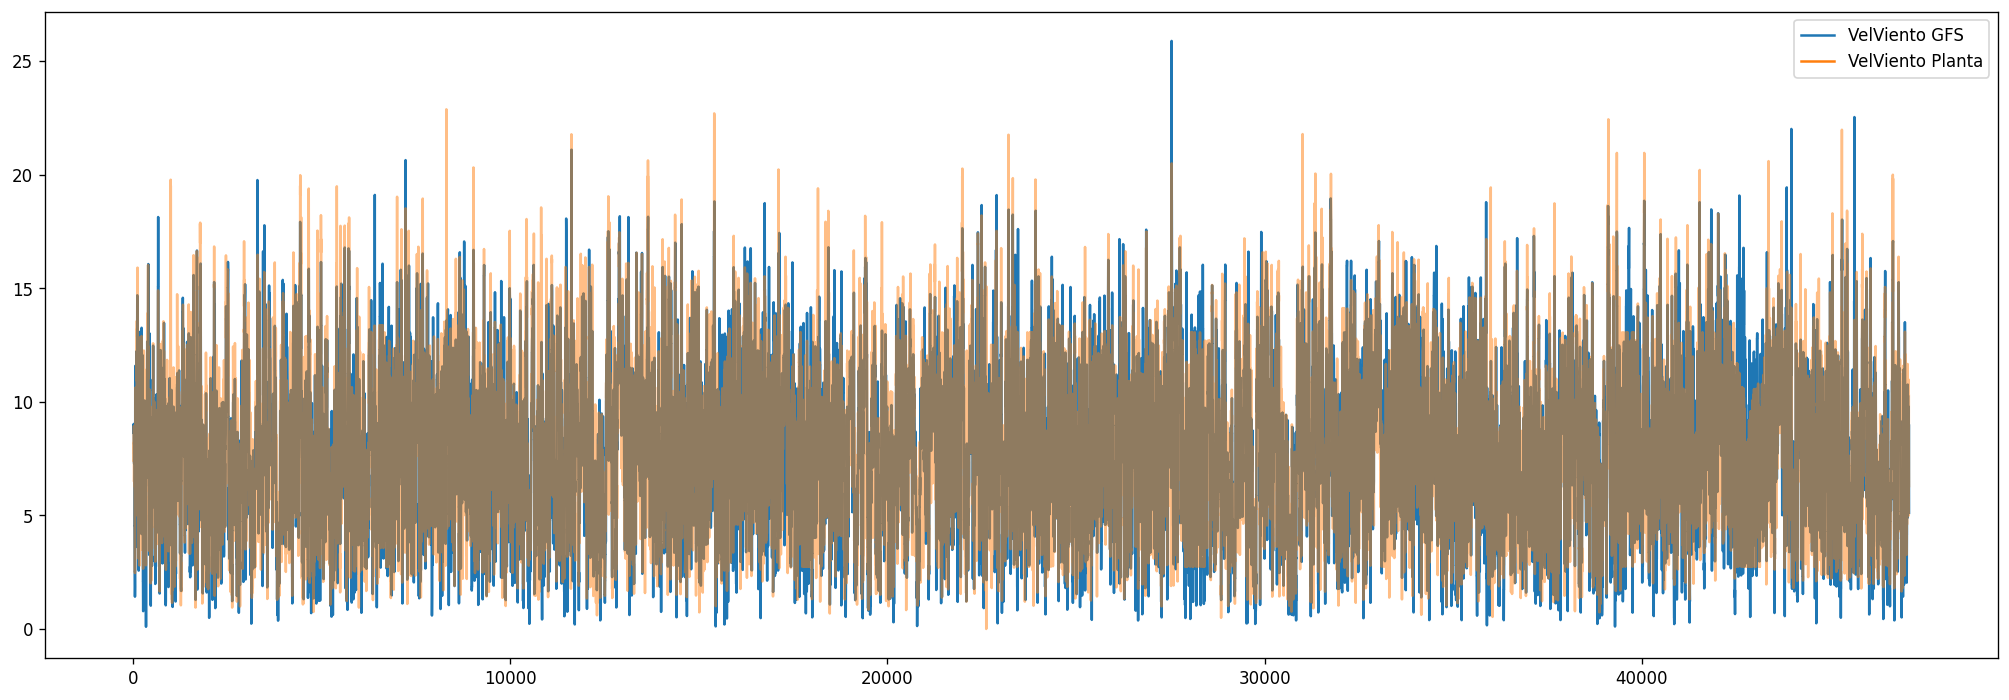

In [70]:
# Plotting specific columns
ax = df_clean_gfs.plot(y=['ws100_gfs', 'wtgs_plant'],label=['VelViento GFS', 'VelViento Planta'])  # Plot both columns

# Adjusting the transparency of a specific line (VelViento) after plotting
lines = ax.get_lines()  # Get the lines in the plot
lines[1].set_alpha(0.5)  # Set transparency (alpha) of the second line (VelViento) to 0.5

plt.show()

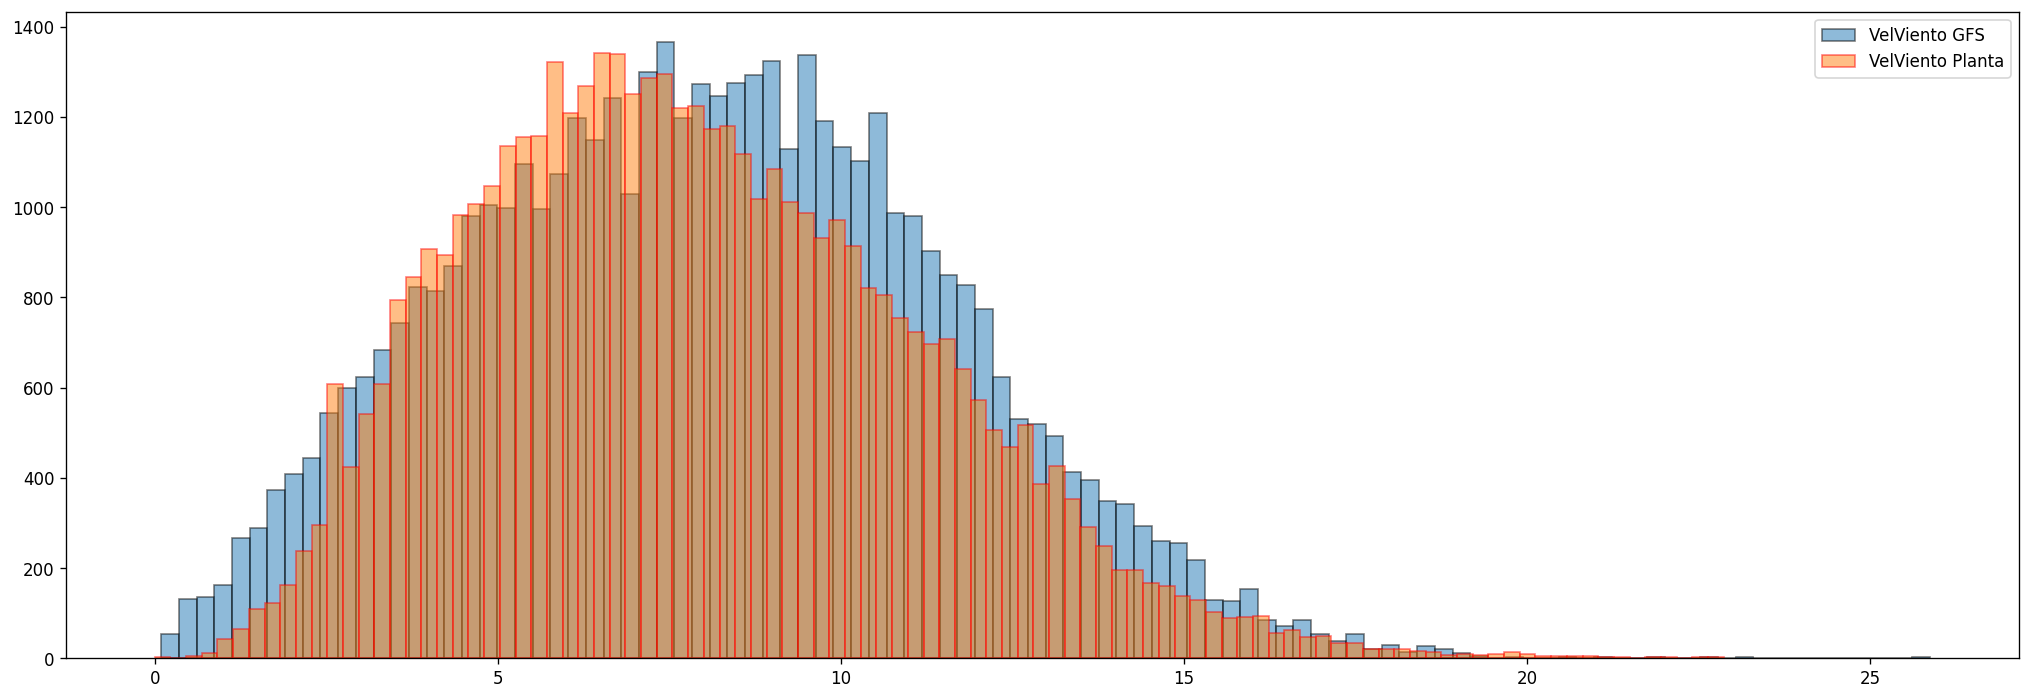

In [71]:
plt.hist(df_clean_gfs['ws100_gfs'], edgecolor='black', alpha=0.5, label='VelViento GFS', bins=100)  # Solid line for Variable 1
plt.hist(df_clean_gfs['wtgs_plant'], edgecolor='red', alpha=0.5, label='VelViento Planta', bins=100)  # Solid line for Variable 2
plt.legend()
plt.show()

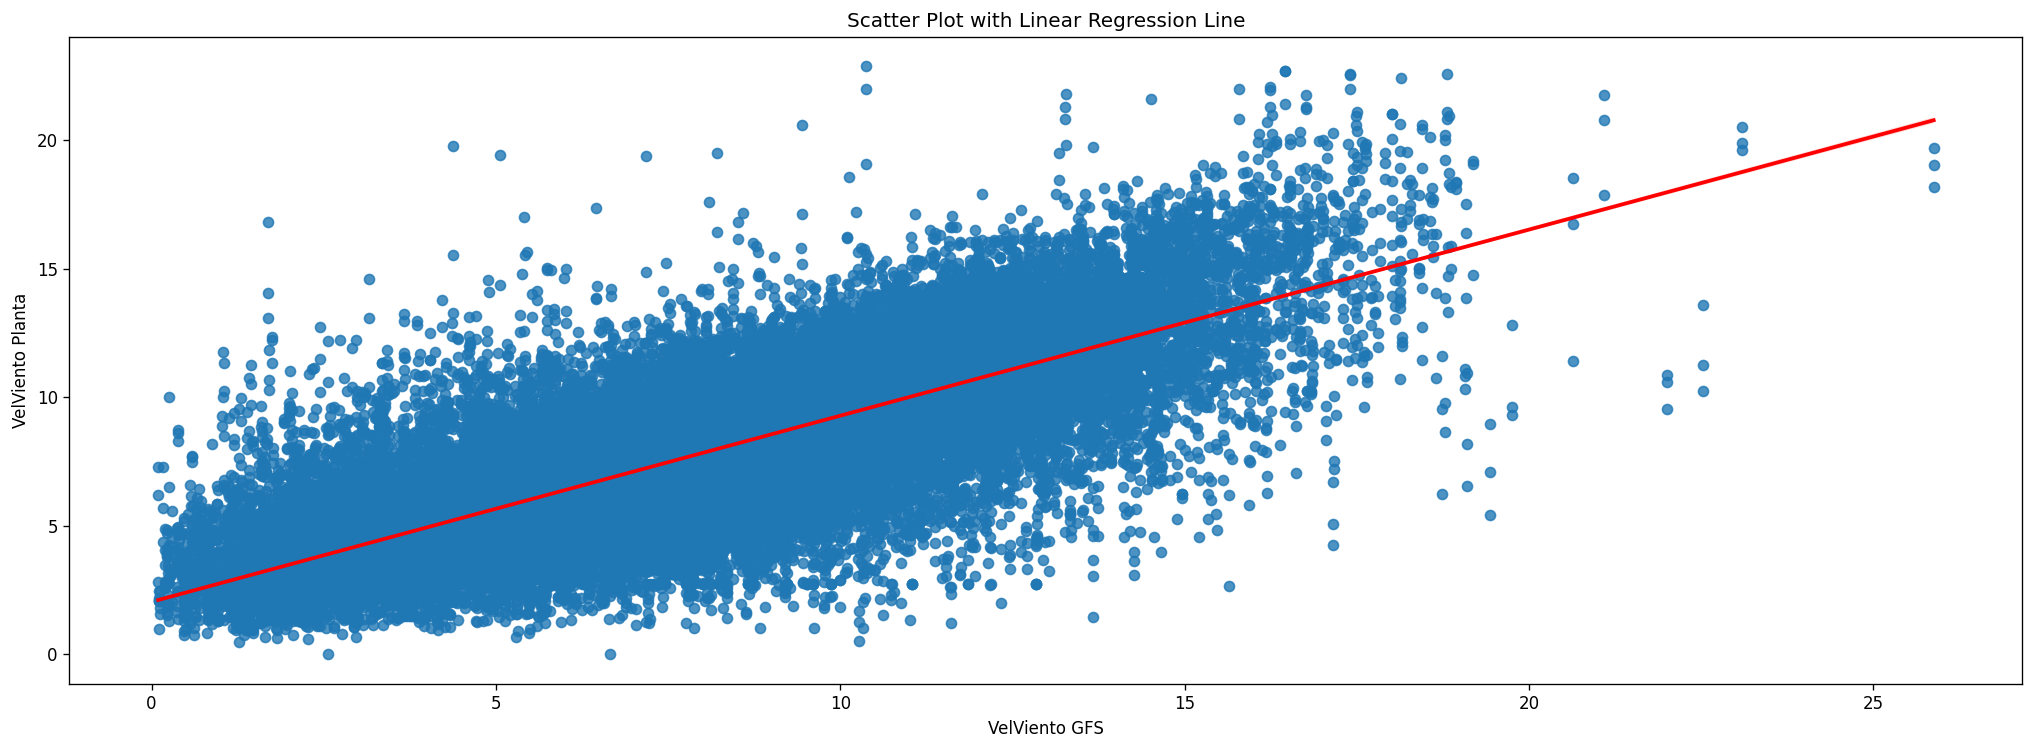

In [72]:
# Scatter plot
sns.regplot(x='ws100_gfs', y='wtgs_plant', data=df_clean_gfs, line_kws={'color': 'red'})
plt.xlabel('VelViento GFS')
plt.ylabel('VelViento Planta')
plt.title('Scatter Plot with Linear Regression Line')
plt.show()

<Axes: >

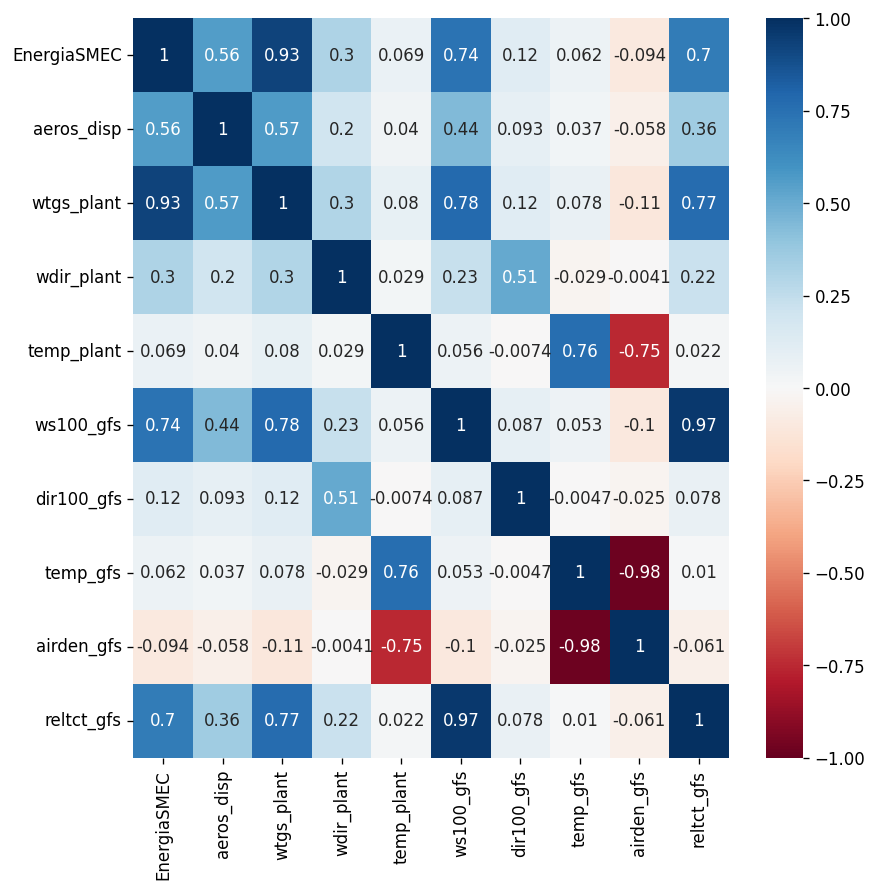

In [73]:
#Matriz de Correlacion
key_vars = ['EnergiaSMEC','aeros_disp','wtgs_plant','wdir_plant','temp_plant','ws100_gfs','dir100_gfs','temp_gfs','airden_gfs','reltct_gfs']

plt.figure(figsize=(8,8))
sns.heatmap(df_clean_gfs[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

### Preparacion de Datos Historicos

In [74]:
# Merge the DataFrames on 'FechaHora'

# Merge df_clean_smn with df_histo_era5
df_histo = df_clean_smn.merge(df_histo_era5, on='FechaHora', how='left')

# Merge the resulting DataFrame with df_histo_gfs
df_histo = df_histo.merge(df_histo_gfs, on='FechaHora', how='left')


In [75]:
#After the merge drop na  checking main columns of each dataset 
df_histo.dropna(subset=['EnergiaSMEC','ws100_ecmwf', 'ws100_gfs' ], inplace=True)

In [76]:
#Rename Columns
df_histo.rename(columns={
  #  'wtgs_plant': 'ws_plant',
    'wspd_smn': 'ws_smn'
}, inplace=True)

In [77]:
# Adding a feature average of forecast ecmwf and gfs
df_histo=wind_average(df_histo, 'ws100_ecmwf','dir100_ecmwf','ws100_gfs','dir100_gfs')

df_histo['temp_avg'] = (df_histo['temp_ecmwf'] + df_histo['temp_gfs'])	/ 2

## _______________________________________________________________________________________________________

### Evaluación de Pronosticos de Vientos Historicos  vs Datos Reales en el Parque Eólico 

In [78]:
df_histo[['FechaHora','ws100_ecmwf','dir100_ecmwf','ws100_gfs','dir100_gfs','dir100_avg','ws100_avg','temp_avg']].head()

FechaHora  ws100_ecmwf  dir100_ecmwf  ws100_gfs  dir100_gfs  \
0 2019-02-02 01:00:00     9.104414    127.141139   8.632441   125.65021   
1 2019-02-02 02:00:00     8.244249    135.365852   8.632441   125.65021   
2 2019-02-02 03:00:00     7.611497    147.347825   9.022401   135.44533   
3 2019-02-02 04:00:00     7.555349    157.854557   9.022401   135.44533   
4 2019-02-02 05:00:00     7.327496    164.895848   9.022401   135.44533   

   dir100_avg  ws100_avg   temp_avg  
0  126.395675   8.868427  19.159385  
1  130.508031   8.438345  18.227713  
2  141.396578   8.316949  17.171822  
3  146.649944   8.288875  17.000357  
4  150.170589   8.174949  16.486966

<Axes: >

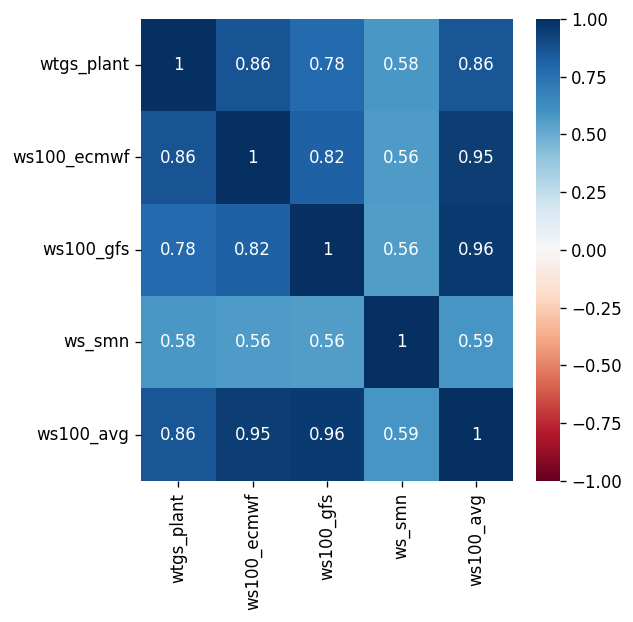

In [79]:
#Matriz de Correlacion
key_vars = ['wtgs_plant','ws100_ecmwf','ws100_gfs','ws_smn','ws100_avg']

plt.figure(figsize=(5,5))
sns.heatmap(df_histo[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

In [80]:
# Add a dummy 'unique_id' column to the DataFrame
df_histo['unique_id'] = 1

In [81]:
# Evaluate models
histo_results = evaluate(
    df=df_histo,
    metrics=[mae, rmse, mape],  
    models=['ws100_ecmwf','ws100_gfs','ws_smn','ws100_avg'],  # Pronosticos de las diferente fuentes
    target_col='wtgs_plant'  # Velocidad en el parque Eólico
)

# Output the results
histo_results.head()

unique_id metric  ws100_ecmwf  ws100_gfs    ws_smn  ws100_avg
0          1    mae     1.286400   1.704855  3.004656   1.288431
1          1   rmse     1.725567   2.259274  3.832022   1.716186
2          1   mape     0.198060   0.267460  0.373702   0.199989

In [82]:
# Transpose the DataFrame
df_histo_results = histo_results.melt(id_vars=['unique_id', 'metric'], 
                  value_vars=['ws100_ecmwf', 'ws100_gfs', 'ws_smn','ws100_avg'], 
                  var_name='model', 
                  value_name='value')

# Drop the 'unique_id' column as it's not needed for plotting
df_histo_results = df_histo_results.drop(columns=['unique_id'])

df_histo_results['value']=df_histo_results['value'].round(2)
df_histo_results.head()

metric        model  value
0    mae  ws100_ecmwf   1.29
1   rmse  ws100_ecmwf   1.73
2   mape  ws100_ecmwf   0.20
3    mae    ws100_gfs   1.70
4   rmse    ws100_gfs   2.26

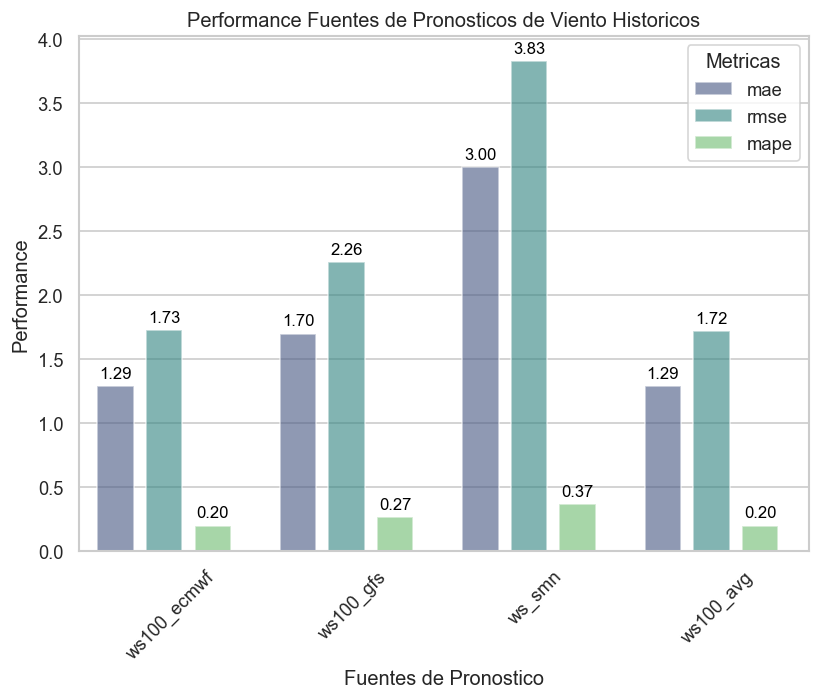

In [83]:

# Set the theme
sns.set_theme(style="whitegrid")

# Create a figure
plt.figure(figsize=(7, 6))  # Width x Height

# Draw a nested barplot
g = sns.barplot(
    data=df_histo_results,
    x="model", y="value", hue="metric",
    palette="viridis", alpha=.6
)

# Customize the plot
plt.title("Performance Fuentes de Pronosticos de Viento Historicos")
plt.xlabel("Fuentes de Pronostico")
plt.ylabel("Performance")
plt.xticks(rotation=45)

# Adjust legend
plt.legend(title="Metricas")

# Adjust the bar width
bar_width = 0.2  # Set the desired bar width

# Annotate each bar
for bar in g.patches:
    bar.set_width(bar_width)
    height = bar.get_height()
    if height > 0.01:  # Skip very small values to avoid clutter
        g.annotate(f'{height:.2f}', 
                   (bar.get_x() + bar.get_width() / 2, height),
                   ha='center', va='bottom',
                   fontsize=10, color='black', xytext=(0, 3),
                   textcoords='offset points')



# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
plt.show()

#### Exportación de dataset de datos historicos para utilizarlo en modelos de predicción

In [84]:
# Selecciona de variables relevantes
ds_histo = df_histo[['FechaHora','EnergiaSMEC','aeros_disp','energia_fc_cammesa','ws100_ecmwf','dir100_ecmwf','temp_ecmwf','ws100_gfs'\
                     ,'dir100_gfs','temp_gfs','ws100_avg','dir100_avg','temp_avg']]

In [85]:
ds_histo.tail()

FechaHora  EnergiaSMEC  aeros_disp  energia_fc_cammesa  \
47056 2024-06-15 17:00:00        45.17       28.50               66.60   
47057 2024-06-15 18:00:00        29.07       27.67               51.35   
47058 2024-06-15 19:00:00        35.32       28.33               38.22   
47059 2024-06-15 20:00:00        27.11       27.67               42.90   
47060 2024-06-15 21:00:00        25.66       29.00               36.01   

       ws100_ecmwf  dir100_ecmwf  temp_ecmwf  ws100_gfs  dir100_gfs  \
47056     7.848835    311.638261   18.150934    9.00076   295.73288   
47057     7.971358    315.620787   15.970237    6.18558   304.20370   
47058     8.312694    318.537880   12.121417    6.18558   304.20370   
47059     8.363186    319.252636   10.820616    6.18558   304.20370   
47060     8.169157    318.508186    9.901987    5.10889   313.42150   

        temp_gfs  ws100_avg  dir100_avg   temp_avg  energia_fc_cammesa  
47056  16.692230   8.424797  303.685571  17.421582               66.60  
47057  16.820770   7.078469  309.912244  16.395504               51.35  
47058  16.820770   7.249137  311.370790  14.471093               38.22  
47059  16.820770   7.274383  311.728168  13.820693               42.90  
47060  14.612152   6.639023  315.964843  12.257069               36.01

In [86]:
# Find the minimum 'FechaHora'
min_fecha_hora_h = ds_histo['FechaHora'].min()

# Find the max 'FechaHora'
max_fecha_hora_h = ds_histo['FechaHora'].max()

# Convert the minimum 'FechaHora' to string (date only)
min_fecha_hora_date_str_h = min_fecha_hora_h.strftime('%d%m%Y')

# Convert the max 'FechaHora' to string (date only)
max_fecha_hora_date_str_h = max_fecha_hora_h.strftime('%d%m%Y')


# Define the file path with the date string
file_path = f'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_histo_{min_fecha_hora_date_str_h}-{max_fecha_hora_date_str_h}.csv'

# Save the DataFrame to a CSV file with the corrected file path
ds_histo.to_csv(file_path, sep=';', index=False, decimal=',')

## _______________________________________________________________________________________________________

### Evaluación de Fuentes de Pronosticos de Vientos a 10 días vs Datos Reales en el Parque Eólico

In [100]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/df_clean_ba2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\PARQUE_LAC\\ds_actual_020624.csv' 
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\PARQUE_LAC\\ds_actual_170624.csv'

df_parque_actual = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                  date_format='%Y-%m-%d %H:%M:%S.%f', delimiter=';', header=0)

#Renombre de columnas
df_parque_actual.rename(columns={
    'ENERGIA_SMEC':'EnergiaSMEC', 
    'VelVientoWTGS': 'wtgs_plant',
    'Nro_Available_WTGs': 'aeros_disp',
    'ENERGIA_PRON_CAMMESA':'energia_fc_cammesa'
}, inplace=True)

#Seleccion de variables de interes y cambio de nombres de columnas
df_parque_actual = df_parque_actual[['FechaHora','EnergiaSMEC','aeros_disp','wtgs_plant','energia_fc_cammesa']]


In [101]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/df_clean_ba2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ECMWF\\ds_ecmwf_fc_2024-06-02.csv' #lote1
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ECMWF\\ds_ecmwf_fc_2024-06-17.csv'  #lote2

df_fc_ecmwf = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                  date_format='%d-%m-%Y %H:%M', delimiter=';', header=0)

In [102]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/df_clean_ba2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\GFS\\ds_fc_gfs_2024-06-02.csv' #lote1
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\GFS\\ds_fc_gfs_2024-06-16.csv' #lote2


df_fc_gfs = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                 date_format='%d-%m-%Y %H:%M', delimiter=';', header=0)

In [103]:
#path = 'https://github.com/guilledesimone/MMA-Tesis/tree/2f25d7f3f7af31da4c44095d98c137454d83e3d8/Datos/df_clean_ba2804.csv'
path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\METEOSTAT\\df_fc_meteostat.csv' #lote1
#path = 'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\METEOSTAT\\ds_fc_smn_2024-06-17.csv' #lote2


df_fc_smn = pd.read_csv(path, decimal=',', parse_dates=['FechaHora'], 
                  date_format='%d-%m-%Y %H:%M', delimiter=';', header=0)

#### Preparacion de datos de pronostico

In [104]:
# Convert 'FechaHora' to datetime format
df_parque_actual['FechaHora'] = pd.to_datetime(df_parque_actual['FechaHora'], yearfirst=True)
df_fc_smn['FechaHora'] = pd.to_datetime(df_fc_smn['FechaHora'], dayfirst=True) 
df_fc_gfs['FechaHora'] = pd.to_datetime(df_fc_gfs['FechaHora'], dayfirst=True)
df_fc_ecmwf['FechaHora'] = pd.to_datetime(df_fc_ecmwf['FechaHora'], yearfirst=True)

In [105]:
# Merge the DataFrames on 'FechaHora'

# Merge df_fc_smn with df_fc_ecmwf
df_fc_actual = df_fc_ecmwf.merge(df_fc_smn, on='FechaHora', how='left')

# Merge the resulting DataFrame with df_fc_gfs
df_fc_actual = df_fc_actual.merge(df_fc_gfs, on='FechaHora', how='left')

# Merge the resulting DataFrame with df_parque_actual
df_fc_actual = df_fc_actual.merge(df_parque_actual, on='FechaHora', how='left')

In [106]:
# Adding a feature average of forecast ecmwf and gfs
df_fc_actual=wind_average(df_fc_actual, 'ws100_ecmwf','dir100_ecmwf','ws100_gfs','dir100_gfs')

df_fc_actual['temp_avg'] = (df_fc_actual['temp_ecmwf'] + df_fc_actual['temp_gfs'])	/ 2

In [107]:
#df_fc_actual.head()

In [108]:
df_fc_actual.rename(columns={
    'wspd': 'ws_smn'
}, inplace=True)

df_fc_actual[['FechaHora','wtgs_plant','ws100_ecmwf','ws100_gfs','ws_smn','ws100_avg']].head()

FechaHora  wtgs_plant  ws100_ecmwf  ws100_gfs  ws_smn  ws100_avg
0 2024-06-02 00:00:00        2.41        2.440   4.643524     2.6   3.541762
1 2024-06-02 01:00:00        2.44        3.847   4.643524     3.6   4.245262
2 2024-06-02 02:00:00        4.27        5.255   4.643524     3.6   4.949262
3 2024-06-02 03:00:00        5.32        6.662   6.711150     3.6   6.686575
4 2024-06-02 04:00:00        6.24        6.920   6.711150     4.1   6.815575

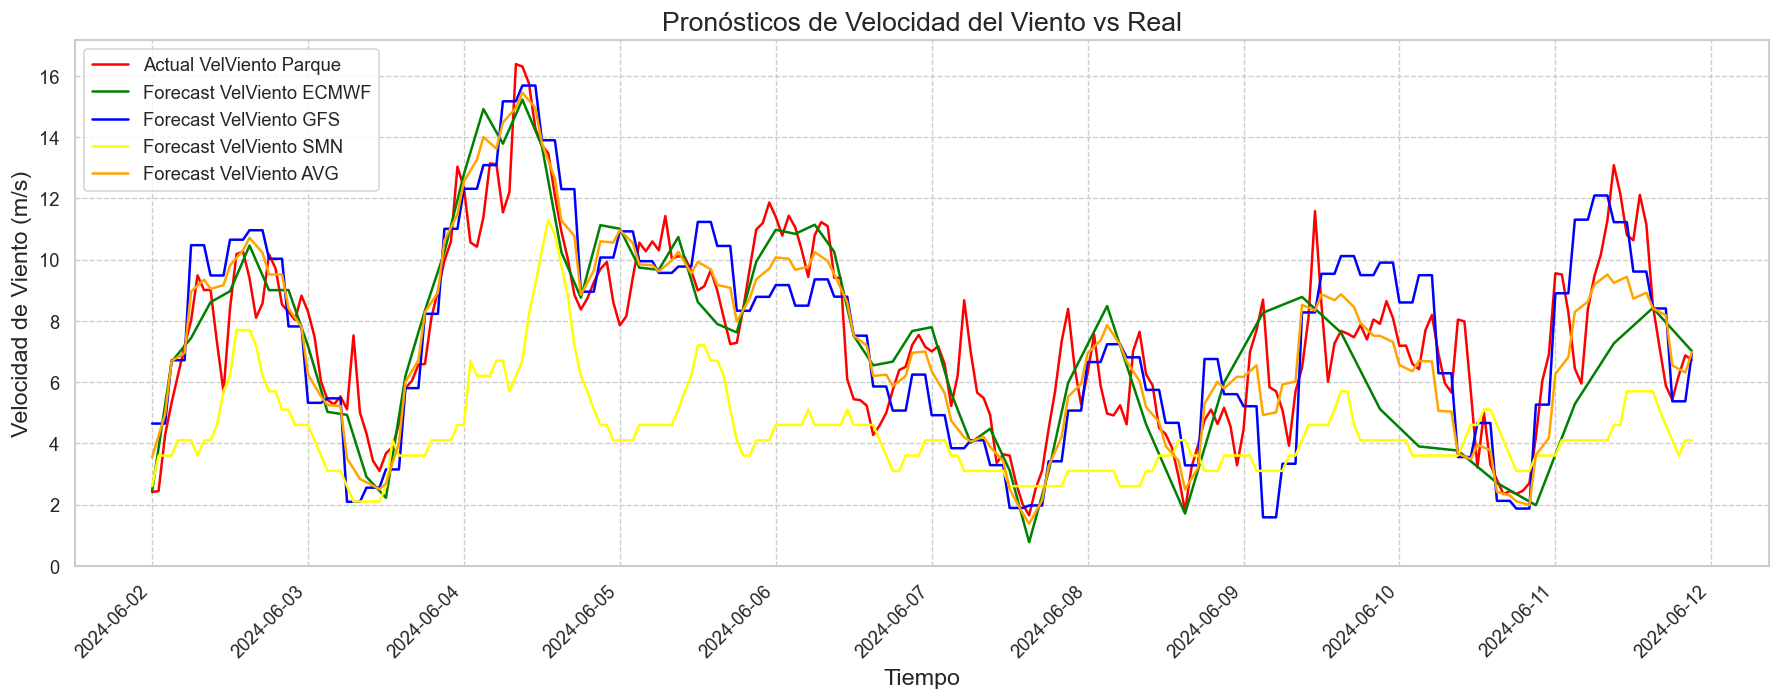

In [109]:
plt.figure(figsize=(15, 6))  # Increase figure width to 15 inches

# Plotting the data
plt.plot(df_fc_actual['FechaHora'], df_fc_actual['wtgs_plant'], label='Actual VelViento Parque', color='red', linewidth=1.5)
plt.plot(df_fc_actual['FechaHora'], df_fc_actual['ws100_ecmwf'], label='Forecast VelViento ECMWF', color='green', linewidth=1.5)
plt.plot(df_fc_actual['FechaHora'], df_fc_actual['ws100_gfs'], label='Forecast VelViento GFS', color='blue', linewidth=1.5)
plt.plot(df_fc_actual['FechaHora'], df_fc_actual['ws_smn'], label='Forecast VelViento SMN', color='yellow', linewidth=1.5)
plt.plot(df_fc_actual['FechaHora'], df_fc_actual['ws100_avg'], label='Forecast VelViento AVG', color='orange', linewidth=1.5)

# Adding title and labels
plt.title('Pronósticos de Velocidad del Viento vs Real', fontsize=16)
plt.xlabel('Tiempo', fontsize=14)
plt.ylabel('Velocidad de Viento (m/s)', fontsize=14)

# Adding legend
plt.legend(loc='best')

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right')

# Adding grid
plt.grid(True, linestyle='--', linewidth=0.8)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

<Axes: >

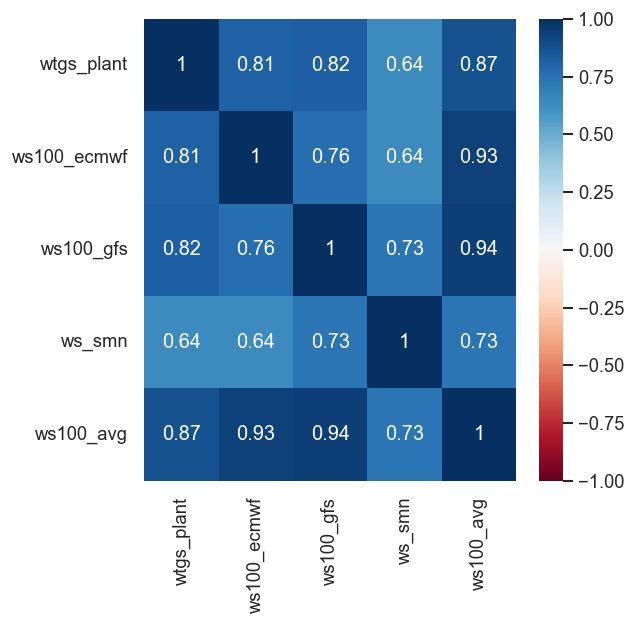

In [110]:
#Matriz de Correlacion
key_vars = ['wtgs_plant','ws100_ecmwf','ws100_gfs','ws_smn','ws100_avg']

plt.figure(figsize=(5,5))
sns.heatmap(df_fc_actual[key_vars].corr(),annot=True,cmap='RdBu',vmin=-1)

#### Evaluación de pronósticos de viento a 10 dias

In [111]:
# Add a dummy 'unique_id' column to the DataFrame
df_fc_actual['unique_id'] = 1

In [112]:
# Evaluate models
results = evaluate(
    df=df_fc_actual,
    metrics=[mae, rmse, mape, smape],  
    models=['ws100_ecmwf','ws100_gfs','ws_smn','ws100_avg'],  # Rronosticos de las diferente fuentes
    target_col='wtgs_plant'  # Velocidad en el parque Eólico
)

# Output the results
results.head()


unique_id metric  ws100_ecmwf  ws100_gfs    ws_smn  ws100_avg
0          1    mae     1.409395   1.491647  3.278824   1.145360
1          1   rmse     1.874024   1.885406  3.867018   1.498243
2          1   mape     0.209454   0.227263  0.413619   0.173344
3          1  smape     0.109599   0.115684  0.264792   0.087676

In [113]:
# Transpose the DataFrame
df_results = results.melt(id_vars=['unique_id', 'metric'], 
                  value_vars=['ws100_ecmwf', 'ws100_gfs', 'ws_smn','ws100_avg'], 
                  var_name='model', 
                  value_name='value')

# Drop the 'unique_id' column as it's not needed for plotting
df_results = df_results.drop(columns=['unique_id'])

df_results['value']=df_results['value'].round(2)
df_results.head(10)

metric        model  value
0    mae  ws100_ecmwf   1.41
1   rmse  ws100_ecmwf   1.87
2   mape  ws100_ecmwf   0.21
3  smape  ws100_ecmwf   0.11
4    mae    ws100_gfs   1.49
5   rmse    ws100_gfs   1.89
6   mape    ws100_gfs   0.23
7  smape    ws100_gfs   0.12
8    mae       ws_smn   3.28
9   rmse       ws_smn   3.87

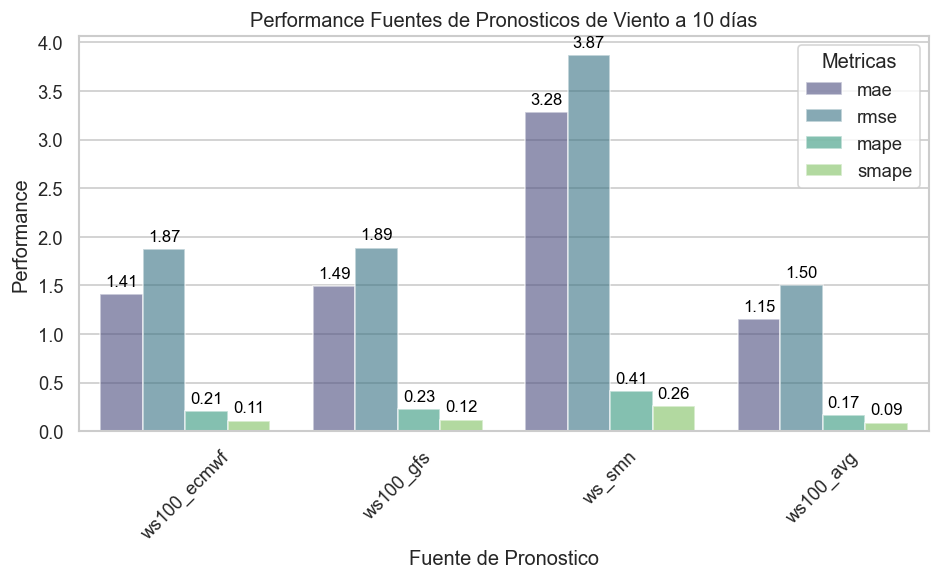

In [114]:

# Set the theme
sns.set_theme(style="whitegrid")

# Create a figure
plt.figure(figsize=(8, 5))  # Width x Height

# Draw a nested barplot
g = sns.barplot(
    data=df_results,
    x="model", y="value", hue="metric",
    palette="viridis", alpha=.6
)

# Customize the plot
plt.title("Performance Fuentes de Pronosticos de Viento a 10 días")
plt.xlabel("Fuente de Pronostico")
plt.ylabel("Performance")
plt.xticks(rotation=45)

# Adjust legend
plt.legend(title="Metricas")

# Adjust the bar width
bar_width = 0.2  # Set the desired bar width

# Annotate each bar
for bar in g.patches:
    bar.set_width(bar_width)
    height = bar.get_height()
    if height > 0.01:  # Skip very small values to avoid clutter
        g.annotate(f'{height:.2f}', 
                   (bar.get_x() + bar.get_width() / 2, height),
                   ha='center', va='bottom',
                   fontsize=10, color='black', xytext=(0, 3),
                   textcoords='offset points')



# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of ylabel
plt.show()

#### Exportación de dataset de datos pronostico a 10 dias para utilizarlo en modelos de predicción

In [115]:
# Seleccion de variables relevantes
df_fc_actual = df_fc_actual[['FechaHora','EnergiaSMEC','aeros_disp','energia_fc_cammesa','ws100_ecmwf','dir100_ecmwf','temp_ecmwf','ws100_gfs'\
                         ,'dir100_gfs','temp_gfs','ws100_avg','dir100_avg','temp_avg']] #,'airden_ecmwf','reltct_ecmwf','airden_gfs','reltct_gfs'

In [116]:
df_fc_actual.tail()

FechaHora  EnergiaSMEC  aeros_disp  energia_fc_cammesa  \
233 2024-06-11 17:00:00        22.04       29.50               40.85   
234 2024-06-11 18:00:00        15.00       30.67               23.70   
235 2024-06-11 19:00:00        26.05       31.00               18.54   
236 2024-06-11 20:00:00        38.85       31.00               29.54   
237 2024-06-11 21:00:00        33.05       31.00               40.03   

     ws100_ecmwf  dir100_ecmwf  temp_ecmwf  ws100_gfs  dir100_gfs   temp_gfs  \
233        7.950        40.279      13.110   8.402156   334.58414  16.834381   
234        7.716        39.111      12.791   5.370385   335.52540  15.929291   
235        7.481        37.943      12.471   5.370385   335.52540  15.929291   
236        7.247        36.774      12.152   5.370385   335.52540  15.929291   
237        7.013        35.606      11.833   6.930823   319.75528  13.615845   

     ws100_avg  dir100_avg   temp_avg  
233   8.176078     7.43157  14.972190  
234   6.543192     7.31820  14.360145  
235   6.425693     6.73420  14.200145  
236   6.308692     6.14970  14.040646  
237   6.971912   357.68064  12.724422

In [122]:
# Find the minimum 'FechaHora'
min_fecha_hora = df_fc_actual['FechaHora'].min()

# Find the max 'FechaHora'
max_fecha_hora = df_fc_actual['FechaHora'].max()

# Convert the minimum 'FechaHora' to string (date only)
min_fecha_hora_date_str = min_fecha_hora.strftime('%d%m%Y')

# Convert the max 'FechaHora' to string (date only)
max_fecha_hora_date_str = max_fecha_hora.strftime('%d%m%Y')


# Define the file path with the date string
file_path = f'D:\\Documents\\MMA\\1.0 Tesis\\Datos\\ds_fc_actual_{min_fecha_hora_date_str}-{max_fecha_hora_date_str}.csv'

# Save the DataFrame to a CSV file with the corrected file path
df_fc_actual.to_csv(file_path, sep=';', index=False, decimal=',')

## _______________________________________________________________________________________________________

### Conclusiones de las Fuentes de Pronostico de Viento

Se evaluaron 3 fuentes de pronosticos a saber:

**1. SMN (Servicio Meteorológico Nacional):** Los datos corresponden a la estación meteorologica del Aerodromo de Bahia Blanca que se encuentra a 30 Km de la planta Eólica, y estan disponibles a la altura de superficie. Al explorar los datos se observan saltos discretos en los valores de velocidad de viento y la distibucion de muestras que no se asimilan a la de la velocidad de viento a 100mts de altura del parque eólico. La dispersión respecto a la recta que expresa la linealidad de las velocidades de viento del parque y del SMN es muy elevada y ademas la correlacion entre la velocidad de viento del SMN y la energia generada es baja 0,51.

**2. GFS (Global Forecast System):** Es un sistema numerico de prediccion de clima operado por el Centro Nacional para las Predicciones Medioambentales  National Centers for Environmental Prediction (NCEP) en los Estados Unidos. Provee pronisticos a escala global con una resolución de 0,25 grados. Cuenta con la posibilidad de descargar de manera gratuita pronosticos históricos con una granularidad de 3 horas y pronósticos futuros hasta 10 dias hacia adelante con granularidad de 3 horas. Adicionalmente permite descargar las variables climáticas de interes a la altura de 100mts proximas a la altura del rotor del aero generador. A partir de los datos de esta fuente se puede observar distribucion de muestras es similar a la de velocidad del viento a la altura del rotor en el parque y la correlación de las velocidades de viento para datos historicos es de 0,78 con una MAE de 1,71 m/s MSE 5,12.

**3. ECMWF (Modelo del Centro Europeo de Pronósticos Meteorológicos a Medio Plazo):** El ECMWF opera uno de los sistemas de pronóstico global más avanzados, proporcionando pronósticos de alta resolución con excelente precisión. Aunque su enfoque principal es Europa, su cobertura es global. En su version abierta al publico ofrece una resolucion de 0,25 grados y pronosticos para los proximos 10 días con una granularidad de 3 horas hasta las 144 hs y 6 hs de las 144 a las 240 hs. La información historica que se dispone de forma abierta al público se puede obtener en ERA5 que es un conjunto de datos de reanálisis atmosférico global de última generación producido por ECMWF, estos datos tienen la ventaja de contar con una granularidad horaria. Otro punto importante es que las variables de viento estan disponibles a la altura de 100mts. 
A partir de los análisis realizados se puede observar una distribucion de muestras de velocidades de viento semejantes, con una correlación de velocidades de viento de 0,86 y MAE 1,29 m/s y MSE 2,98.

Sin embargo para un muestra de pronostico de 10 dias, tuvo una performance levemente mejor la fuente GFS respecto a ECMWF 

Las fuentes de pronostico que se utilizaran para los modelos de prediccion de energia generada seran ECMWF y GFS



